# Predicting Vaccination Rate
___
The discussion of vaccines has been a controversial topic especially during the COVID-19 era. Despite the effectiveness of vaccines, the rate in which vaccines are administered will be affected by an amalgamation of variables. A model can be created in order to predict whether a person given a set of conditions will ultimately decide on taking the vaccine. With the best-fit model, Pfizer can manufacture certain vaccines to maximize their profits.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preparing the datasets and analysis

In [2]:
test_set_features_df = pd.read_csv('test_set_features.csv', index_col='respondent_id')
training_df = pd.read_csv('training_set_features.csv', index_col='respondent_id')
training_labels = pd.read_csv('training_set_labels.csv', index_col='respondent_id')

The `training_df` contains the features (the variables that may affect vaccination rate) whereas `training_labels` contains the labels (1 for being vaccinated and 0 for not being vaccinated). To begin our data cleaning process we will have to concatenate the two dataframes first, and check data types and if there are any null values.

In [3]:
df = pd.concat([training_labels, training_df], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

There is a total of 26707 respondents in this dataset. And from the infomation provided there are columns with null values. Some columns contain few null values like `h1n1_concern` and `behavioral_face_mask`. These can be easily filled by using `SimpleImputer()` from sklearn. However, columns like `employment_industry` and `employment_occupation` have plenty null values. We can fill in these null values by analyzing other columns and seeing how the these columns are related.

## Data cleaning

When dealing with null values in numerical columns, we can just run it through `SimpleImputer()`. For  categorical null values, we will replace the null values with the string `'None'`. This will allow us to locate null values later by using `.str.contains()`.

In [4]:
# getting the names of each categorical column
cat_col = training_df.columns[training_df.dtypes == 'object'].values

# fill null values for both dataframes
df[cat_col] = df[cat_col].fillna('None')
test_set_features_df[cat_col] = test_set_features_df[cat_col].fillna('None')

We can now create a function that will replace `None` with another string like `Not working` and `No Job Title` so that we know this particular subject is unemployed. This function will get replace most of the `None` values for `employment_industry`, `employment_occupation`, and `health_worker` into something more descriptive. The null values in `health_worker` column, although not being a categorical column, can also be replaced with an integar value `0` (implying the subject is not a health worker).

In [5]:
def unemployment(DataFrame):
    
    # create three data sets where each have values that indicate some level of unemployment
    not_in_labor = DataFrame.loc[DataFrame['employment_status'].str.contains('Not in Labor Force')]
    unemployed = DataFrame.loc[DataFrame['employment_status'].str.contains('Unemployed')]
    none = DataFrame.loc[DataFrame['employment_status'].str.contains('None')]
    
    # concatenate the three dataframes
    # we need to mask the index of the concatenated data
    # using the masked index, we can replace 'None' with another string that describes unemployment
    no_job = pd.concat([not_in_labor, unemployed, none])
    mask = no_job.index
    DataFrame.loc[mask, 'employment_industry'] = 'Not working'
    DataFrame.loc[mask, 'employment_occupation'] = 'No Job Title'
    
    # similar process but with the 'health_worker' column
    mask2 = no_job.loc[no_job['health_worker'].isna()].index
    DataFrame.loc[mask2, 'health_worker'] = 0

Run the function for both datasets (`df` and `test_set_features_df`) and investigate if the changes went through correctly.

In [6]:
unemployment(df)
unemployment(test_set_features_df)
df['employment_industry'].value_counts()

Not working    13147
fcxhlnwr        2468
wxleyezf        1804
ldnlellj        1231
pxcmvdjn        1037
atmlpfrs         926
arjwrbjb         871
xicduogh         851
mfikgejo         614
vjjrobsf         527
rucpziij         523
xqicxuve         511
saaquncn         338
cfqqtusy         325
nduyfdeo         286
mcubkhph         275
wlfvacwt         215
dotnnunm         201
None             183
haxffmxo         148
msuufmds         124
phxvnwax          89
qnlwzans          13
Name: employment_industry, dtype: int64

After running the dataframe through the function, we can see that most of the null values are filled in. For the remaining null values, which is now indicated as `'None'`, we can either delete or keep them. I ended up keeping it to preserve data.

## Vaccination rate

Once the data is cleaned, we can observe the vaccination rate given a variable. If the vaccination rate does not change significantly, we can omit the column.

This function will return the vaccination rate of each feature.

In [7]:
def vaccination_rate(vaccine, col, dataframe):
    
    #groups the dataframe according to the feature and the vaccine taken
    freq = dataframe[[vaccine, col]].groupby([vaccine, col]).size().unstack(vaccine)
    
    #creates a column that calculates the vaccination rate for each feature value
    freq['Vaccination Rate'] = freq[1] / (freq[0] + freq[1])
    return freq

We can construct a for loop that will return a dataframe containing the vaccination rate of both the h1n1 and seasonal flu vaccine.

In [8]:
cols = training_df.columns.values
for col in cols:
    if col != 'h1n1_vaccine':
        display(vaccination_rate('h1n1_vaccine', col, df))
        display(vaccination_rate('seasonal_vaccine', col, df))

h1n1_vaccine,0,1,Vaccination Rate
h1n1_concern,,,
0.0,2849,447,0.135619
1.0,6756,1397,0.171348
2.0,8102,2473,0.233853
3.0,3250,1341,0.292093


seasonal_vaccine,0,1,Vaccination Rate
h1n1_concern,,,
0.0,2254,1042,0.316141
1.0,4811,3342,0.409910
2.0,5135,5440,0.514421
3.0,2022,2569,0.559573


h1n1_vaccine,0,1,Vaccination Rate
h1n1_knowledge,,,
0.0,2145,361,0.144054
1.0,11945,2653,0.181737
2.0,6849,2638,0.278065


seasonal_vaccine,0,1,Vaccination Rate
h1n1_knowledge,,,
0.0,1588,918,0.366321
1.0,8290,6308,0.432114
2.0,4334,5153,0.543164


h1n1_vaccine,0,1,Vaccination Rate
behavioral_antiviral_meds,,,
0.0,20061,5274,0.208171
1.0,930,371,0.285165


seasonal_vaccine,0,1,Vaccination Rate
behavioral_antiviral_meds,,,
0.0,13571,11764,0.464338
1.0,678,623,0.478862


h1n1_vaccine,0,1,Vaccination Rate
behavioral_avoidance,,,
0.0,5954,1317,0.181131
1.0,14904,4324,0.224880


seasonal_vaccine,0,1,Vaccination Rate
behavioral_avoidance,,,
0.0,4337,2934,0.403521
1.0,9827,9401,0.488922


h1n1_vaccine,0,1,Vaccination Rate
behavioral_face_mask,,,
0.0,19765,5082,0.204532
1.0,1255,586,0.318305


seasonal_vaccine,0,1,Vaccination Rate
behavioral_face_mask,,,
0.0,13449,11398,0.458727
1.0,815,1026,0.557306


h1n1_vaccine,0,1,Vaccination Rate
behavioral_wash_hands,,,
0.0,3971,679,0.146022
1.0,17027,4988,0.226573


seasonal_vaccine,0,1,Vaccination Rate
behavioral_wash_hands,,,
0.0,3052,1598,0.343656
1.0,11196,10819,0.491438


h1n1_vaccine,0,1,Vaccination Rate
behavioral_large_gatherings,,,
0.0,13536,3537,0.207169
1.0,7424,2123,0.222374


seasonal_vaccine,0,1,Vaccination Rate
behavioral_large_gatherings,,,
0.0,9533,7540,0.441633
1.0,4695,4852,0.508222


h1n1_vaccine,0,1,Vaccination Rate
behavioral_outside_home,,,
0.0,14004,3640,0.206302
1.0,6959,2022,0.225142


seasonal_vaccine,0,1,Vaccination Rate
behavioral_outside_home,,,
0.0,9766,7878,0.446497
1.0,4464,4517,0.502951


h1n1_vaccine,0,1,Vaccination Rate
behavioral_touch_face,,,
0.0,7117,1461,0.170319
1.0,13806,4195,0.233043


seasonal_vaccine,0,1,Vaccination Rate
behavioral_touch_face,,,
0.0,5330,3248,0.378643
1.0,8876,9125,0.506916


h1n1_vaccine,0,1,Vaccination Rate
doctor_recc_h1n1,,,
0.0,16529,2610,0.136371
1.0,2529,2879,0.532359


seasonal_vaccine,0,1,Vaccination Rate
doctor_recc_h1n1,,,
0.0,11046,8093,0.422854
1.0,1827,3581,0.662167


h1n1_vaccine,0,1,Vaccination Rate
doctor_recc_seasonal,,,
0.0,13783,2670,0.162280
1.0,5275,2819,0.348283


seasonal_vaccine,0,1,Vaccination Rate
doctor_recc_seasonal,,,
0.0,10756,5697,0.346259
1.0,2117,5977,0.738448


h1n1_vaccine,0,1,Vaccination Rate
chronic_med_condition,,,
0.0,14962,3484,0.188876
1.0,5282,2008,0.275446


seasonal_vaccine,0,1,Vaccination Rate
chronic_med_condition,,,
0.0,10789,7657,0.415104
1.0,2890,4400,0.603567


h1n1_vaccine,0,1,Vaccination Rate
child_under_6_months,,,
0.0,18874,4875,0.205272
1.0,1486,652,0.304958


seasonal_vaccine,0,1,Vaccination Rate
child_under_6_months,,,
0.0,12673,11076,0.466378
1.0,1094,1044,0.488307


h1n1_vaccine,0,1,Vaccination Rate
health_worker,,,
0.0,19314,4486,0.188487
1.0,1712,1187,0.409452


seasonal_vaccine,0,1,Vaccination Rate
health_worker,,,
0.0,13242,10558,0.443613
1.0,1023,1876,0.647120


h1n1_vaccine,0,1,Vaccination Rate
health_insurance,,,
0.0,1480,256,0.147465
1.0,8663,4034,0.317713


seasonal_vaccine,0,1,Vaccination Rate
health_insurance,,,
0.0,1338,398,0.229263
1.0,5866,6831,0.538001


h1n1_vaccine,0,1,Vaccination Rate
opinion_h1n1_vacc_effective,,,
1.0,844,42,0.047404
2.0,1763,95,0.051130
3.0,4224,499,0.105653
4.0,9622,2061,0.176410
5.0,4265,2901,0.404828


seasonal_vaccine,0,1,Vaccination Rate
opinion_h1n1_vacc_effective,,,
1.0,699,187,0.211061
2.0,1381,477,0.256728
3.0,2727,1996,0.422613
4.0,6444,5239,0.448429
5.0,2778,4388,0.612336


h1n1_vaccine,0,1,Vaccination Rate
opinion_h1n1_risk,,,
1.0,7420,719,0.088340
2.0,8253,1666,0.167960
3.0,923,194,0.173679
4.0,3279,2115,0.392102
5.0,856,894,0.510857


seasonal_vaccine,0,1,Vaccination Rate
opinion_h1n1_risk,,,
1.0,5407,2732,0.335668
2.0,5402,4517,0.455389
3.0,540,577,0.516562
4.0,2029,3365,0.623841
5.0,653,1097,0.626857


h1n1_vaccine,0,1,Vaccination Rate
opinion_h1n1_sick_from_vacc,,,
1.0,7157,1841,0.204601
2.0,7548,1581,0.173184
3.0,136,12,0.081081
4.0,4304,1546,0.264274
5.0,1574,613,0.280293


seasonal_vaccine,0,1,Vaccination Rate
opinion_h1n1_sick_from_vacc,,,
1.0,4986,4012,0.445877
2.0,4837,4292,0.470150
3.0,86,62,0.418919
4.0,2914,2936,0.501880
5.0,1199,988,0.451760


h1n1_vaccine,0,1,Vaccination Rate
opinion_seas_vacc_effective,,,
1.0,1132,89,0.072891
2.0,2001,205,0.092928
3.0,1054,162,0.133224
4.0,9579,2050,0.176283
5.0,6897,3076,0.308433


seasonal_vaccine,0,1,Vaccination Rate
opinion_seas_vacc_effective,,,
1.0,1028,193,0.158067
2.0,1885,321,0.145512
3.0,876,340,0.279605
4.0,7253,4376,0.376301
5.0,2945,7028,0.704703


h1n1_vaccine,0,1,Vaccination Rate
opinion_seas_risk,,,
1.0,5468,506,0.084700
2.0,7541,1413,0.157807
3.0,541,136,0.200886
4.0,5295,2335,0.306029
5.0,1776,1182,0.399594


seasonal_vaccine,0,1,Vaccination Rate
opinion_seas_risk,,,
1.0,4723,1251,0.209407
2.0,5613,3341,0.373129
3.0,300,377,0.556869
4.0,2568,5062,0.663434
5.0,755,2203,0.744760


h1n1_vaccine,0,1,Vaccination Rate
opinion_seas_sick_from_vacc,,,
1.0,9252,2618,0.220556
2.0,6183,1450,0.189965
3.0,86,8,0.085106
4.0,3740,1112,0.229184
5.0,1333,388,0.225450


seasonal_vaccine,0,1,Vaccination Rate
opinion_seas_sick_from_vacc,,,
1.0,5782,6088,0.512890
2.0,4391,3242,0.424735
3.0,77,17,0.180851
4.0,2622,2230,0.459604
5.0,1059,662,0.384660


h1n1_vaccine,0,1,Vaccination Rate
age_group,,,
18 - 34 Years,4224,991,0.190029
35 - 44 Years,3087,761,0.197765
45 - 54 Years,4218,1020,0.194731
55 - 64 Years,4212,1351,0.242855
65+ Years,5292,1551,0.226655


seasonal_vaccine,0,1,Vaccination Rate
age_group,,,
18 - 34 Years,3731,1484,0.284564
35 - 44 Years,2453,1395,0.362526
45 - 54 Years,3136,2102,0.401298
55 - 64 Years,2719,2844,0.511235
65+ Years,2233,4610,0.673681


h1n1_vaccine,0,1,Vaccination Rate
education,,,
12 Years,4726,1071,0.184751
< 12 Years,1968,395,0.167160
College Graduate,7614,2483,0.245915
None,1146,261,0.185501
Some College,5579,1464,0.207866


seasonal_vaccine,0,1,Vaccination Rate
education,,,
12 Years,3199,2598,0.448163
< 12 Years,1415,948,0.401185
College Graduate,4933,5164,0.511439
None,865,542,0.385217
Some College,3860,3183,0.451938


h1n1_vaccine,0,1,Vaccination Rate
race,,,
Black,1803,315,0.148725
Hispanic,1390,365,0.207977
Other or Multiple,1263,349,0.216501
White,16577,4645,0.218877


seasonal_vaccine,0,1,Vaccination Rate
race,,,
Black,1377,741,0.349858
Hispanic,1159,596,0.339601
Other or Multiple,935,677,0.419975
White,10801,10421,0.491047


h1n1_vaccine,0,1,Vaccination Rate
sex,,,
Female,12378,3480,0.219448
Male,8655,2194,0.202231


seasonal_vaccine,0,1,Vaccination Rate
sex,,,
Female,7970,7888,0.497415
Male,6302,4547,0.419117


h1n1_vaccine,0,1,Vaccination Rate
income_poverty,,,
"<= $75,000, Above Poverty",10178,2599,0.203412
"> $75,000",5087,1723,0.253010
Below Poverty,2181,516,0.191324
None,3587,836,0.189012


seasonal_vaccine,0,1,Vaccination Rate
income_poverty,,,
"<= $75,000, Above Poverty",6686,6091,0.476716
"> $75,000",3427,3383,0.496769
Below Poverty,1719,978,0.362625
None,2440,1983,0.448338


h1n1_vaccine,0,1,Vaccination Rate
marital_status,,,
Married,10387,3168,0.233714
None,1152,256,0.181818
Not Married,9494,2250,0.191587


seasonal_vaccine,0,1,Vaccination Rate
marital_status,,,
Married,6856,6699,0.494209
None,860,548,0.389205
Not Married,6556,5188,0.441757


h1n1_vaccine,0,1,Vaccination Rate
rent_or_own,,,
None,1646,396,0.193928
Own,14577,4159,0.221979
Rent,4810,1119,0.188733


seasonal_vaccine,0,1,Vaccination Rate
rent_or_own,,,
None,1186,856,0.419197
Own,9354,9382,0.500747
Rent,3732,2197,0.370552


h1n1_vaccine,0,1,Vaccination Rate
employment_status,,,
Employed,10637,2923,0.215560
None,1192,271,0.185236
Not in Labor Force,7988,2243,0.219236
Unemployed,1216,237,0.163111


seasonal_vaccine,0,1,Vaccination Rate
employment_status,,,
Employed,7839,5721,0.421903
None,896,567,0.387560
Not in Labor Force,4523,5708,0.557912
Unemployed,1014,439,0.302134


h1n1_vaccine,0,1,Vaccination Rate
hhs_geo_region,,,
atmpeygn,1591,442,0.217413
bhuqouqj,2110,736,0.258609
dqpwygqj,933,193,0.171403
fpwskwrf,2607,658,0.201531
kbazzjca,2291,567,0.198390
lrircsnp,1641,437,0.210298
lzgpxyit,3523,774,0.180126
mlyzmhmf,1726,517,0.230495
oxchjgsf,2199,660,0.230850


seasonal_vaccine,0,1,Vaccination Rate
hhs_geo_region,,,
atmpeygn,1031,1002,0.492868
bhuqouqj,1433,1413,0.496486
dqpwygqj,637,489,0.434281
fpwskwrf,1717,1548,0.474119
kbazzjca,1482,1376,0.481456
lrircsnp,1219,859,0.413378
lzgpxyit,2349,1948,0.453340
mlyzmhmf,1235,1008,0.449398
oxchjgsf,1520,1339,0.468346


h1n1_vaccine,0,1,Vaccination Rate
census_msa,,,
"MSA, Not Principle City",9178,2467,0.211851
"MSA, Principle City",6183,1681,0.213759
Non-MSA,5672,1526,0.212003


seasonal_vaccine,0,1,Vaccination Rate
census_msa,,,
"MSA, Not Principle City",6076,5569,0.478231
"MSA, Principle City",4296,3568,0.453713
Non-MSA,3900,3298,0.458183


h1n1_vaccine,0,1,Vaccination Rate
household_adults,,,
0.0,6471,1585,0.196748
1.0,11209,3265,0.225577
2.0,2240,563,0.200856
3.0,903,222,0.197333


seasonal_vaccine,0,1,Vaccination Rate
household_adults,,,
0.0,4079,3977,0.493669
1.0,7600,6874,0.474921
2.0,1691,1112,0.396718
3.0,717,408,0.362667


h1n1_vaccine,0,1,Vaccination Rate
household_children,,,
0.0,14689,3983,0.213314
1.0,2501,674,0.212283
2.0,2235,629,0.219623
3.0,1398,349,0.199771


seasonal_vaccine,0,1,Vaccination Rate
household_children,,,
0.0,9217,9455,0.506373
1.0,1953,1222,0.384882
2.0,1769,1095,0.382332
3.0,1148,599,0.342873


h1n1_vaccine,0,1,Vaccination Rate
employment_industry,,,
None,163,20,0.109290
Not working,10396,2751,0.209249
arjwrbjb,663,208,0.238806
atmlpfrs,802,124,0.133909
cfqqtusy,278,47,0.144615
dotnnunm,179,22,0.109453
fcxhlnwr,1486,982,0.397893
haxffmxo,56,92,0.621622
ldnlellj,1019,212,0.172218


seasonal_vaccine,0,1,Vaccination Rate
employment_industry,,,
None,124,59,0.322404
Not working,6433,6714,0.510687
arjwrbjb,470,401,0.460390
atmlpfrs,579,347,0.374730
cfqqtusy,207,118,0.363077
dotnnunm,130,71,0.353234
fcxhlnwr,893,1575,0.638169
haxffmxo,23,125,0.844595
ldnlellj,762,469,0.380991


h1n1_vaccine,0,1,Vaccination Rate
employment_occupation,,,
No Job Title,10396,2751,0.209249
None,260,63,0.195046
bxpfxfdn,242,89,0.268882
ccgxvspp,290,51,0.149560
cmhcxjea,660,587,0.470730
dcjcmpih,56,92,0.621622
dlvbwzss,164,63,0.277533
emcorrxb,970,300,0.236220
haliazsg,188,108,0.364865


seasonal_vaccine,0,1,Vaccination Rate
employment_occupation,,,
No Job Title,6433,6714,0.510687
None,189,134,0.414861
bxpfxfdn,181,150,0.453172
ccgxvspp,221,120,0.351906
cmhcxjea,389,858,0.688051
dcjcmpih,23,125,0.844595
dlvbwzss,131,96,0.422907
emcorrxb,690,580,0.456693
haliazsg,120,176,0.594595


From the data provided above we can see how the vaccination rate for both h1n1 and seasonal vaccine are affected by each feature.

For the h1n1 vaccine we can determine that values in `'behavioral_large_gatherings'`, `'behavioral_outside_home'`, `'opinion_seas_sick_from_vacc'`, `'sex'`, `'census_msa'`, and `'household_children'` had little difference in vaccination rate.

For seasonal vaccine `'behavioral_antiviral_meds'`, `'child_under_6_months'`, `'opinion_h1n1_sick_from_vacc'`, and `'census_msa'` had the smallest differences.

We can drop these columns when preparing our training and testing sets.

## Preparing our training and testing sets

Training and testing sets are important in getting the optimal model. We want the model to be as accurate and precise as possible. We also want the model to not overfit the training data. By splitting the data into two sets, we can see if there are any overfitting or underfitting. Before performing a split we need to define our target (y) and features (X).

In [9]:
# features for h1n1 vaccine
X_h1n1 = df.drop(['h1n1_vaccine',
                  'seasonal_vaccine',
                  'behavioral_large_gatherings',
                  'behavioral_outside_home',
                  'opinion_seas_sick_from_vacc',
                  'sex',
                  'census_msa',
                  'household_children'], axis=1)

# features for seasonal flu vaccine
X_seasonal = df.drop(['h1n1_vaccine',
                      'seasonal_vaccine',
                      'behavioral_antiviral_meds',
                      'child_under_6_months',
                      'opinion_h1n1_sick_from_vacc',
                      'census_msa'], axis=1)

y_h1n1 = training_labels['h1n1_vaccine']
y_seasonal = training_labels['seasonal_vaccine']

Perform a train_test_split with a test size of 0.33 and a random state of 42 to maintain the same random sets throughout.

In [10]:
from sklearn.model_selection import train_test_split

# train and test sets for h1n1 vaccine
X_train_h1n1, X_test_h1n1, y_train_h1n1, y_test_h1n1 = train_test_split(X_h1n1, training_labels['h1n1_vaccine'],
                                                                        test_size=0.33, random_state=42,
                                                                        stratify=training_labels['h1n1_vaccine'])

# train and test sets for seasonal vaccine
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = train_test_split(X_seasonal,
                                                                                        training_labels['seasonal_vaccine'],
                                                                                        test_size=0.33, random_state=42,
                                                                                        stratify=training_labels['seasonal_vaccine'])

## Constructing the pipeline

Importing appropriate classes to set up our pipeline.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

A function will be made to prevent redundancy as we have to run two datasets (h1n1 vaccine and seasonal vaccine) through the pipeline. This function will create a training set that is worked through the pipeline consisting of `SimpleImputer()` and `StandardScaler()` for numerical data, and `OneHotEncoder()` for categorical data. The two resulting arrays are then combined by using `ColumnTransformer()`. 

In [12]:
def pipelines(X, y, num_col, cat_col):
    
    numerical_data = Pipeline([('imputer', SimpleImputer(strategy='median')),
                               ('scaler', StandardScaler())])
    categorical_data = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    
    transform_data = ColumnTransformer(transformers=[('num', numerical_data, num_col),
                                                     ('cat', categorical_data, cat_col)], remainder='drop')
    
    full_pipeline = Pipeline([('transformer', transform_data),
                              ('estimator', estimator),])
    
    return full_pipeline.fit(X, y)

Get the names of each numerical and categorical columns from both data sets.

In [13]:
num_col_h1n1 = X_h1n1.columns[X_h1n1.dtypes != 'object'].values
cat_col_h1n1 = X_h1n1.columns[X_h1n1.dtypes == 'object'].values

num_col_seasonal = X_seasonal.columns[X_seasonal.dtypes != 'object'].values
cat_col_seasonal = X_seasonal.columns[X_seasonal.dtypes == 'object'].values

The next function will return the accuracy score of the model.

In [14]:
def pipelines_score(full_pipeline, X_test, y_test):
    
    return full_pipeline.score(X_test, y_test)

The following function will return the log loss (uncertainty/entropy) value of the models. This is another way in determining which model to use for making our prediction.

In [15]:
def log_loss_model(full_pipeline, X_train, y_train):
    
    model = full_pipeline
    
    model_log_loss = cross_val_score(model, X_train, y_train, scoring='neg_log_loss')
    model_log_loss_avg = -np.average(model_log_loss)
    return model_log_loss_avg

## Logistic model

Our first predictive model is the logistic function. The parameters used are the ones I am most familiar with but any can be used as long as the random state is 42 to maintain consistency.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

estimator = LogisticRegression(solver='liblinear', fit_intercept=False, C=1e12, random_state=42)

### Accuracy of the logistic model

In [17]:
pipelines_score(pipelines(X_train_h1n1,
                          y_train_h1n1,
                          num_col_h1n1,
                          cat_col_h1n1),
                X_test_h1n1,
                y_test_h1n1
               )

0.8363966417063762

In [18]:
pipelines_score(pipelines(X_train_seasonal,
                          y_train_seasonal,
                          num_col_seasonal,
                          cat_col_seasonal),
                X_test_seasonal,
                y_test_seasonal
               )

0.7785341502155662

The accuracy score of the h1n1 and seasonal models are `0.8363966417063762` and `0.7785341502155662` respectively.

### Log loss of the logistic model

In [19]:
log_loss_model(pipelines(X_train_h1n1,
                          y_train_h1n1,
                          num_col_h1n1,
                          cat_col_h1n1),
               X_test_h1n1,
               y_test_h1n1
)

0.39071503358530224

In [20]:
log_loss_model(pipelines(X_train_seasonal,
                          y_train_seasonal,
                          num_col_seasonal,
                          cat_col_seasonal),
               X_test_seasonal,
               y_test_seasonal
)

0.48588659272987356

The log loss for the logistic model for the h1n1 and seasonal is `0.39071503358530224` and `0.48588659272987356` respectively.

## KNN model

Next is the KNN model which works by grouping the nearest data points together. The hyper parameters can be altered to get the optimal model.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### P-value
 The different p values provides different methods in calculating the nearest neighbors. We will find the optimal p value for the h1n1 and seasonal vaccine separately.

In [22]:
estimator = KNeighborsClassifier(p=1)

In [23]:
%%time
print('Accuracy score for h1n1: ', pipelines_score(pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1), X_test_h1n1, y_test_h1n1),
      '\nAccuracy score for seasonal ', pipelines_score(pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal), X_test_seasonal, y_test_seasonal))

Accuracy score for h1n1:  0.813138189244384 
Accuracy score for seasonal  0.7238484229634672
Wall time: 36.2 s


In [24]:
estimator = KNeighborsClassifier(p=2)

In [25]:
%%time
print('Accuracy score for h1n1: ', pipelines_score(pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1), X_test_h1n1, y_test_h1n1),
      '\nAccuracy score for seasonal ', pipelines_score(pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal), X_test_seasonal, y_test_seasonal))

Accuracy score for h1n1:  0.8107556160653506 
Accuracy score for seasonal  0.7229407760381211
Wall time: 6.44 s


We will set `p=2` due to the interest in time and the accuracy score is not too different from `p=1` which had slightly higher accuracy scores.
### Finding the best k value (nearest neighbor)
The k value groups up specific number of samples together within a certain distance. Those samples are then considered to be similar. A for loop can be used to determine the best k value.

In [26]:
%%time
accuracy = []
for i in range(5,70):
    estimator = KNeighborsClassifier(p=2, n_neighbors=i)
    accuracy.append(pipelines_score(pipelines(X_train_h1n1,
                                              y_train_h1n1,
                                              num_col_h1n1,
                                              cat_col_h1n1),
                                    X_test_h1n1,
                                    y_test_h1n1
                    )
    
    )

Wall time: 3min 50s


In [27]:
%%time
accuracy_seasonal = []
for i in range(5,70):
    estimator = KNeighborsClassifier(p=2, n_neighbors=i)
    accuracy_seasonal.append(pipelines_score(pipelines(X_train_seasonal,
                                              y_train_seasonal,
                                              num_col_seasonal,
                                              cat_col_seasonal),
                                    X_test_seasonal,
                                    y_test_seasonal
                    )
    
    )

Wall time: 4min 30s


The accuracy list contains the accuracy scores according to the `n_neighbors`. This list can then be plotted to determine the best k value.

<Figure size 2000x1200 with 0 Axes>

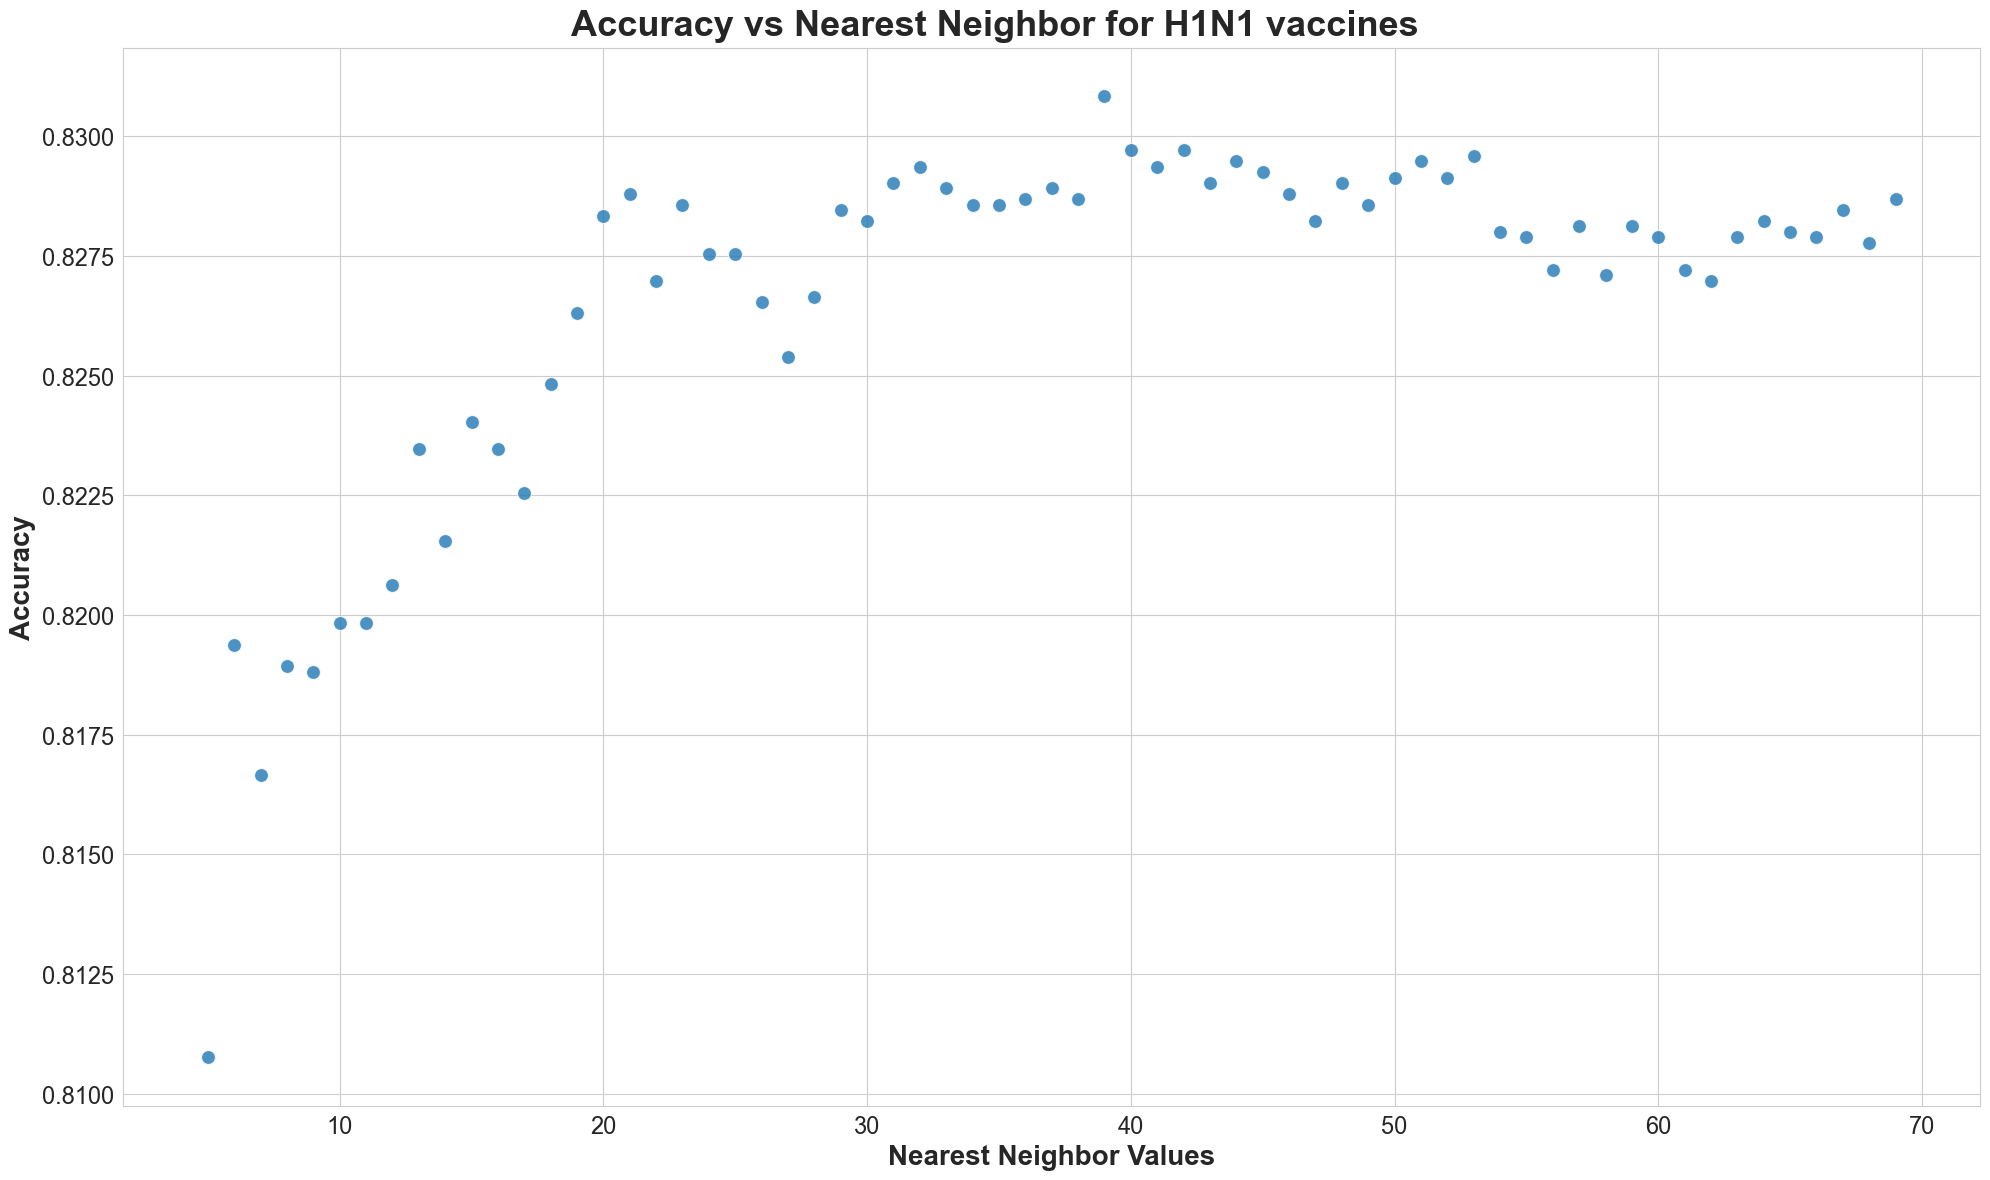

In [28]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

sns.scatterplot(x=range(5,70), y=accuracy, legend='full', alpha=0.8, s=100, palette='Set2')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Accuracy vs Nearest Neighbor for H1N1 vaccines", fontweight='bold', fontsize=26)
ax.set_xlabel("Nearest Neighbor Values", fontsize=20, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=20, fontweight='bold')

plt.tight_layout();

<Figure size 2000x1200 with 0 Axes>

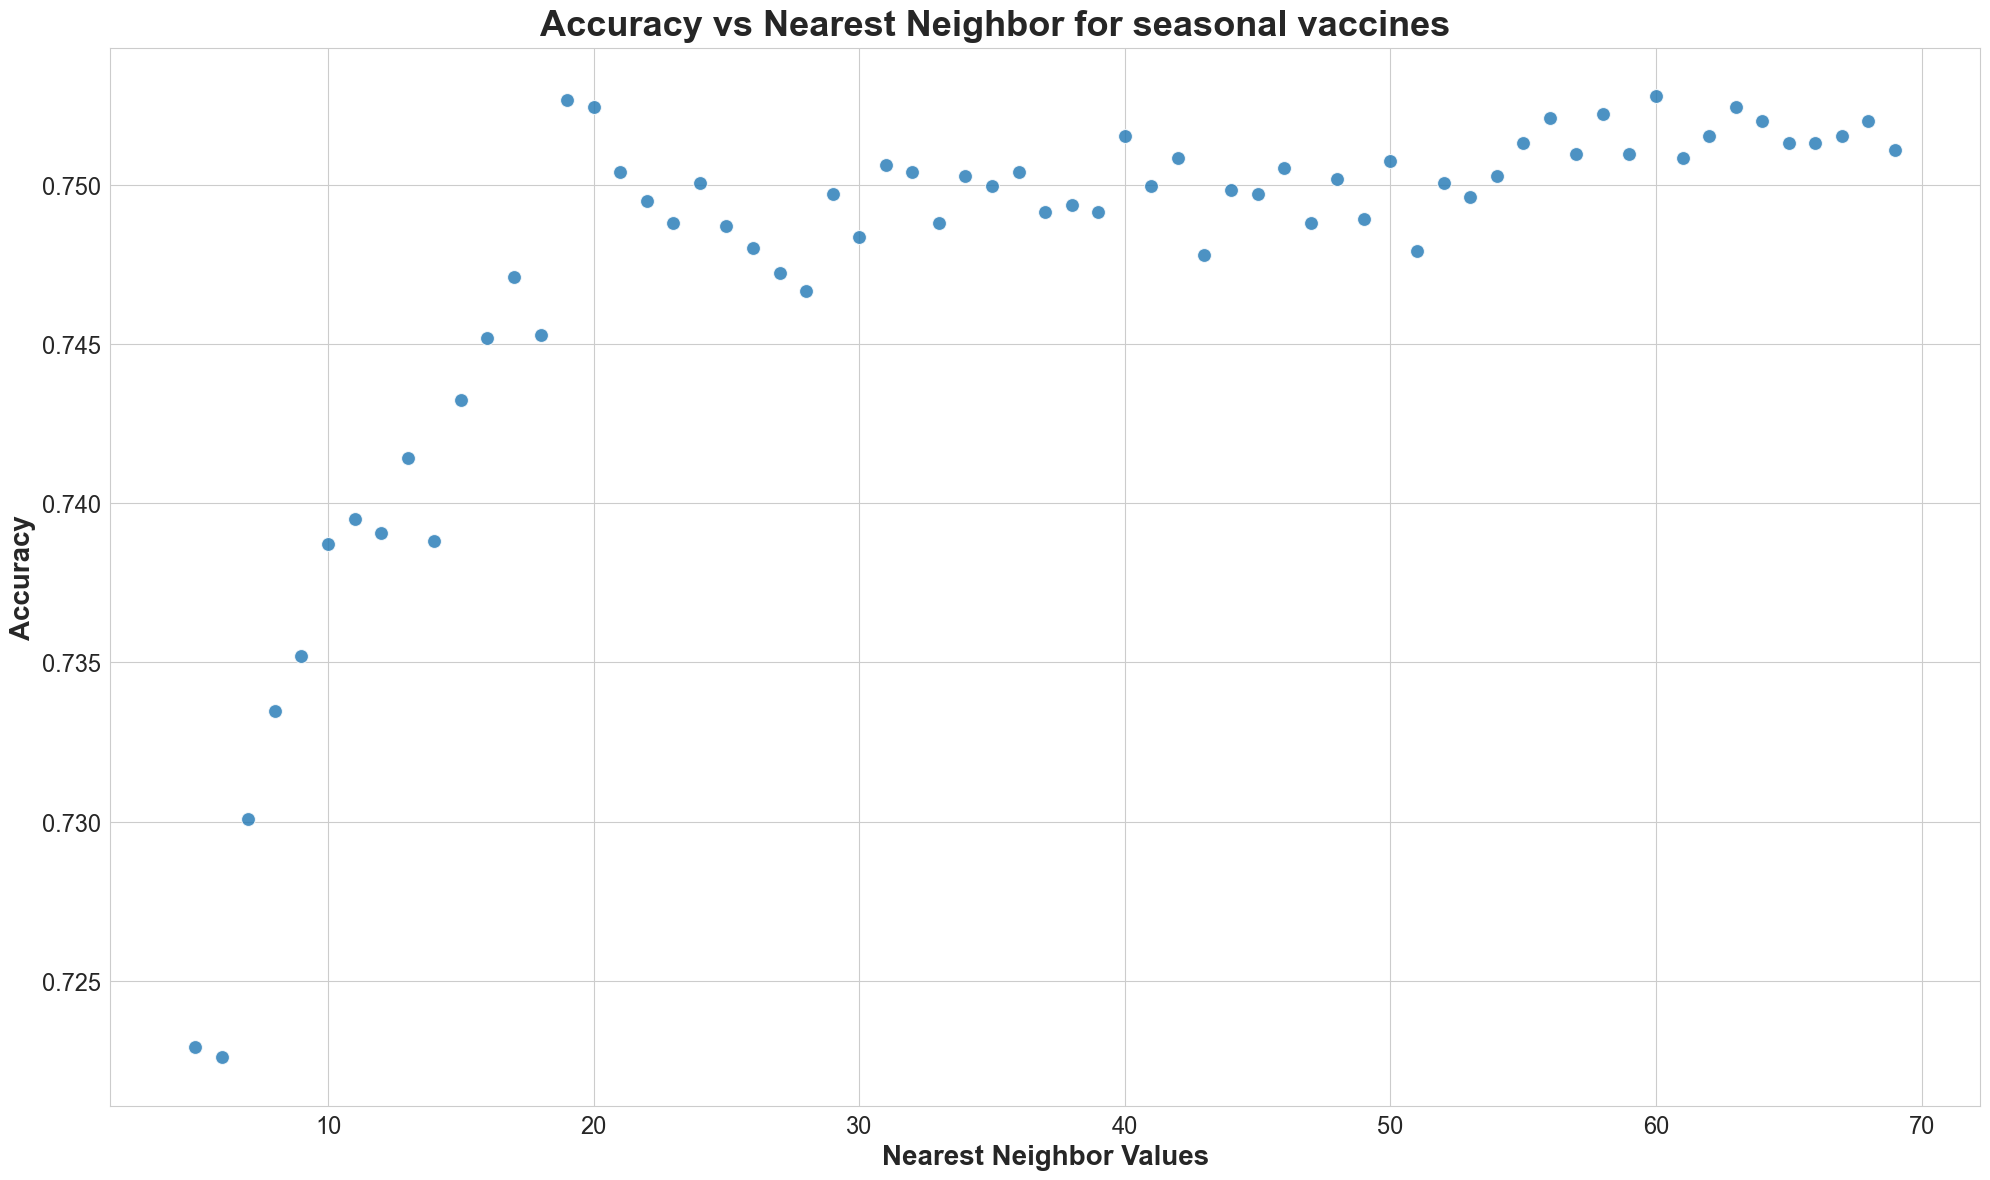

In [29]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

sns.scatterplot(x=range(5,70), y=accuracy_seasonal, legend='full', alpha=0.8, s=100, palette='Set2')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Accuracy vs Nearest Neighbor for seasonal vaccines", fontweight='bold', fontsize=26)
ax.set_xlabel("Nearest Neighbor Values", fontsize=20, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=20, fontweight='bold')

plt.tight_layout();

It seems that a k value of 39 returns the highest accuracy score for the h1n1 vaccine, whereas a k value of 19 or 60 for the seasonal vaccine is best.

In [30]:
def accuracy_and_log_loss(X_train, X_test, y_train, y_test, num_col, cat_col):
    print(
        'Accuracy score: ', pipelines_score(pipelines(X_train,
                              y_train,
                              num_col,
                              cat_col),
                    X_test,
                    y_test
                   ),
        '\nLog loss: ', log_loss_model(pipelines(X_train,
                              y_train,
                              num_col,
                              cat_col),
                   X_test,
                   y_test
    )
    )

In [31]:
estimator = KNeighborsClassifier(p=2, n_neighbors=39)
accuracy_and_log_loss(X_train_h1n1, X_test_h1n1, y_train_h1n1, y_test_h1n1, num_col_h1n1, cat_col_h1n1)

Accuracy score:  0.8308373042886317 
Log loss:  0.4480907468854573


Since the seasonal vaccine has two possible k values that return the highest accuracy score, we will calculate the scores for both values.

In [32]:
estimator = KNeighborsClassifier(p=2, n_neighbors=60)
accuracy_and_log_loss(X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal, num_col_seasonal, cat_col_seasonal)

Accuracy score:  0.7527796687088723 
Log loss:  0.5304935192050005


The accuracy score and log loss of the h1n1 model is `0.8308373042886317` and `0.4480907468854573`.
Whereas the accuracy score and log loss of the seasonal model (`k=60`) is `0.7527796687088723` and `0.5304935192050005`.
The accuracy score is slightly worse than the logistic model but there is a significant difference between the log loss values. This may be due to the large number of data values as KNN is not the best option for large datasets.

## Decision tree model

The last model will be the decision tree where it performs splits to group up data points. Similar to KNN, we can create several for loops to determine the best value for each hyperparameters.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

### Max depths
This determines how deep the tree will go. It takes in integer values, and a for loop that goes through a range of numbers and be made to determine the optimal value for `max_depth`.

In [34]:
max_depths = np.linspace(1, 30, num=30)

train_results = []
test_results = []
average_log_loss_max_depth=[]
for i in max_depths:
    estimator = DecisionTreeClassifier(random_state=42, max_depth=i)
    
    dt = pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1)
    
    dt_log_loss = cross_val_score(dt, X_train_h1n1, y_train_h1n1, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_max_depth.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_h1n1)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_h1n1, y_hat_train)
    train_results.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_h1n1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_h1n1, y_hat_test)
    test_results.append(auc(false_positive_rate, true_positive_rate))

In [35]:
train_results_seasonal = []
test_results_seasonal = []
average_log_loss_max_depth_seasonal=[]
for i in max_depths:
    estimator = DecisionTreeClassifier(random_state=42, max_depth=i)
    
    dt = pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal)
    
    dt_log_loss = cross_val_score(dt, X_train_seasonal, y_train_seasonal, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_max_depth_seasonal.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_seasonal)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_seasonal, y_hat_train)
    train_results_seasonal.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_seasonal)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_seasonal, y_hat_test)
    test_results_seasonal.append(auc(false_positive_rate, true_positive_rate))

Once the list of average_log_loss is created, we can run it through a function that returns tuples containing the input (`i`) and the output (`average_log_loss`).

In [36]:
def average_log_loss_list(loss_list, start=1):
    
    return [(idx, item) for idx,item in enumerate(loss_list, start=start)]

In [37]:
average_log_loss_list(average_log_loss_max_depth)

[(1, 0.45215701552998205),
 (2, 0.42238517181103397),
 (3, 0.4086981770553095),
 (4, 0.39948849155796595),
 (5, 0.42511290825495296),
 (6, 0.4666842162665052),
 (7, 0.5679744983609096),
 (8, 0.7365327326887801),
 (9, 1.0706455306438472),
 (10, 1.5169347704045555),
 (11, 1.9622673735710716),
 (12, 2.547358823754384),
 (13, 3.116443877699476),
 (14, 3.7108496686412087),
 (15, 4.390904461878499),
 (16, 4.990325731425601),
 (17, 5.561217344836476),
 (18, 6.023509549726201),
 (19, 6.51061997307283),
 (20, 6.9544861700384475),
 (21, 7.301387445801902),
 (22, 7.583937442755042),
 (23, 7.747685207842837),
 (24, 7.948968721289951),
 (25, 8.14193663538302),
 (26, 8.199076487651372),
 (27, 8.2588292161883),
 (28, 8.377828818104199),
 (29, 8.417900607328892),
 (30, 8.387731740550256)]

In [38]:
average_log_loss_list(average_log_loss_max_depth_seasonal)

[(1, 0.6237356538192664),
 (2, 0.576434204647305),
 (3, 0.5416743986527287),
 (4, 0.5217152349572884),
 (5, 0.512215929055431),
 (6, 0.5300466440820406),
 (7, 0.6444687105031419),
 (8, 0.8469991174096159),
 (9, 1.2066797666083384),
 (10, 1.6661215951174746),
 (11, 2.400668078229757),
 (12, 3.266463761806589),
 (13, 4.067105232978836),
 (14, 4.801677224151201),
 (15, 5.58354245862405),
 (16, 6.420501742587345),
 (17, 6.997552480787927),
 (18, 7.721528973362143),
 (19, 8.309556207721732),
 (20, 8.87312303549758),
 (21, 9.222786494851961),
 (22, 9.595757971890567),
 (23, 9.850830288333361),
 (24, 10.051447967228354),
 (25, 10.269184255687053),
 (26, 10.40784991194642),
 (27, 10.483074071765197),
 (28, 10.638052595524197),
 (29, 10.698921188493909),
 (30, 10.795291856983818)]

It seems that the lowest log loss is somewhere between 3 and 6 for both the h1n1 and seasonal vaccine. We can use those two values to graphically determine the best `max_depth` value.

In [39]:
def graph_auc(num_list, train_results, test_results, min_x=1, max_x=2, hyperparameter='parameter'):
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=(12,8), dpi=200)
    
    plt.title('AUC score according to {}'.format(hyperparameter), fontdict={'fontsize': 20})
    
    #create two curves, one for train and another for test
    plt.plot(num_list, train_results, label='Train AUC')
    plt.plot(num_list, test_results, label='Test AUC')
    
    #plot the min and max values that had the lowest log loss values
    plt.axvline(x=min_x, color='red')
    plt.axvline(x=max_x, color='cyan')
    
    plt.ylabel('AUC score', fontsize=15)
    plt.xlabel('{}'.format(hyperparameter), fontsize=15)
    plt.legend()
    return plt.show()

This function returns the plot of AUC scores. We want to use the value that will get us the greatest AUC score but at the same time that is not too far apart from one another. We also want to look between the range that has the least log loss, indicated by the vertical lines. We will set the `min_x` to 3 and `max_x` to 7.

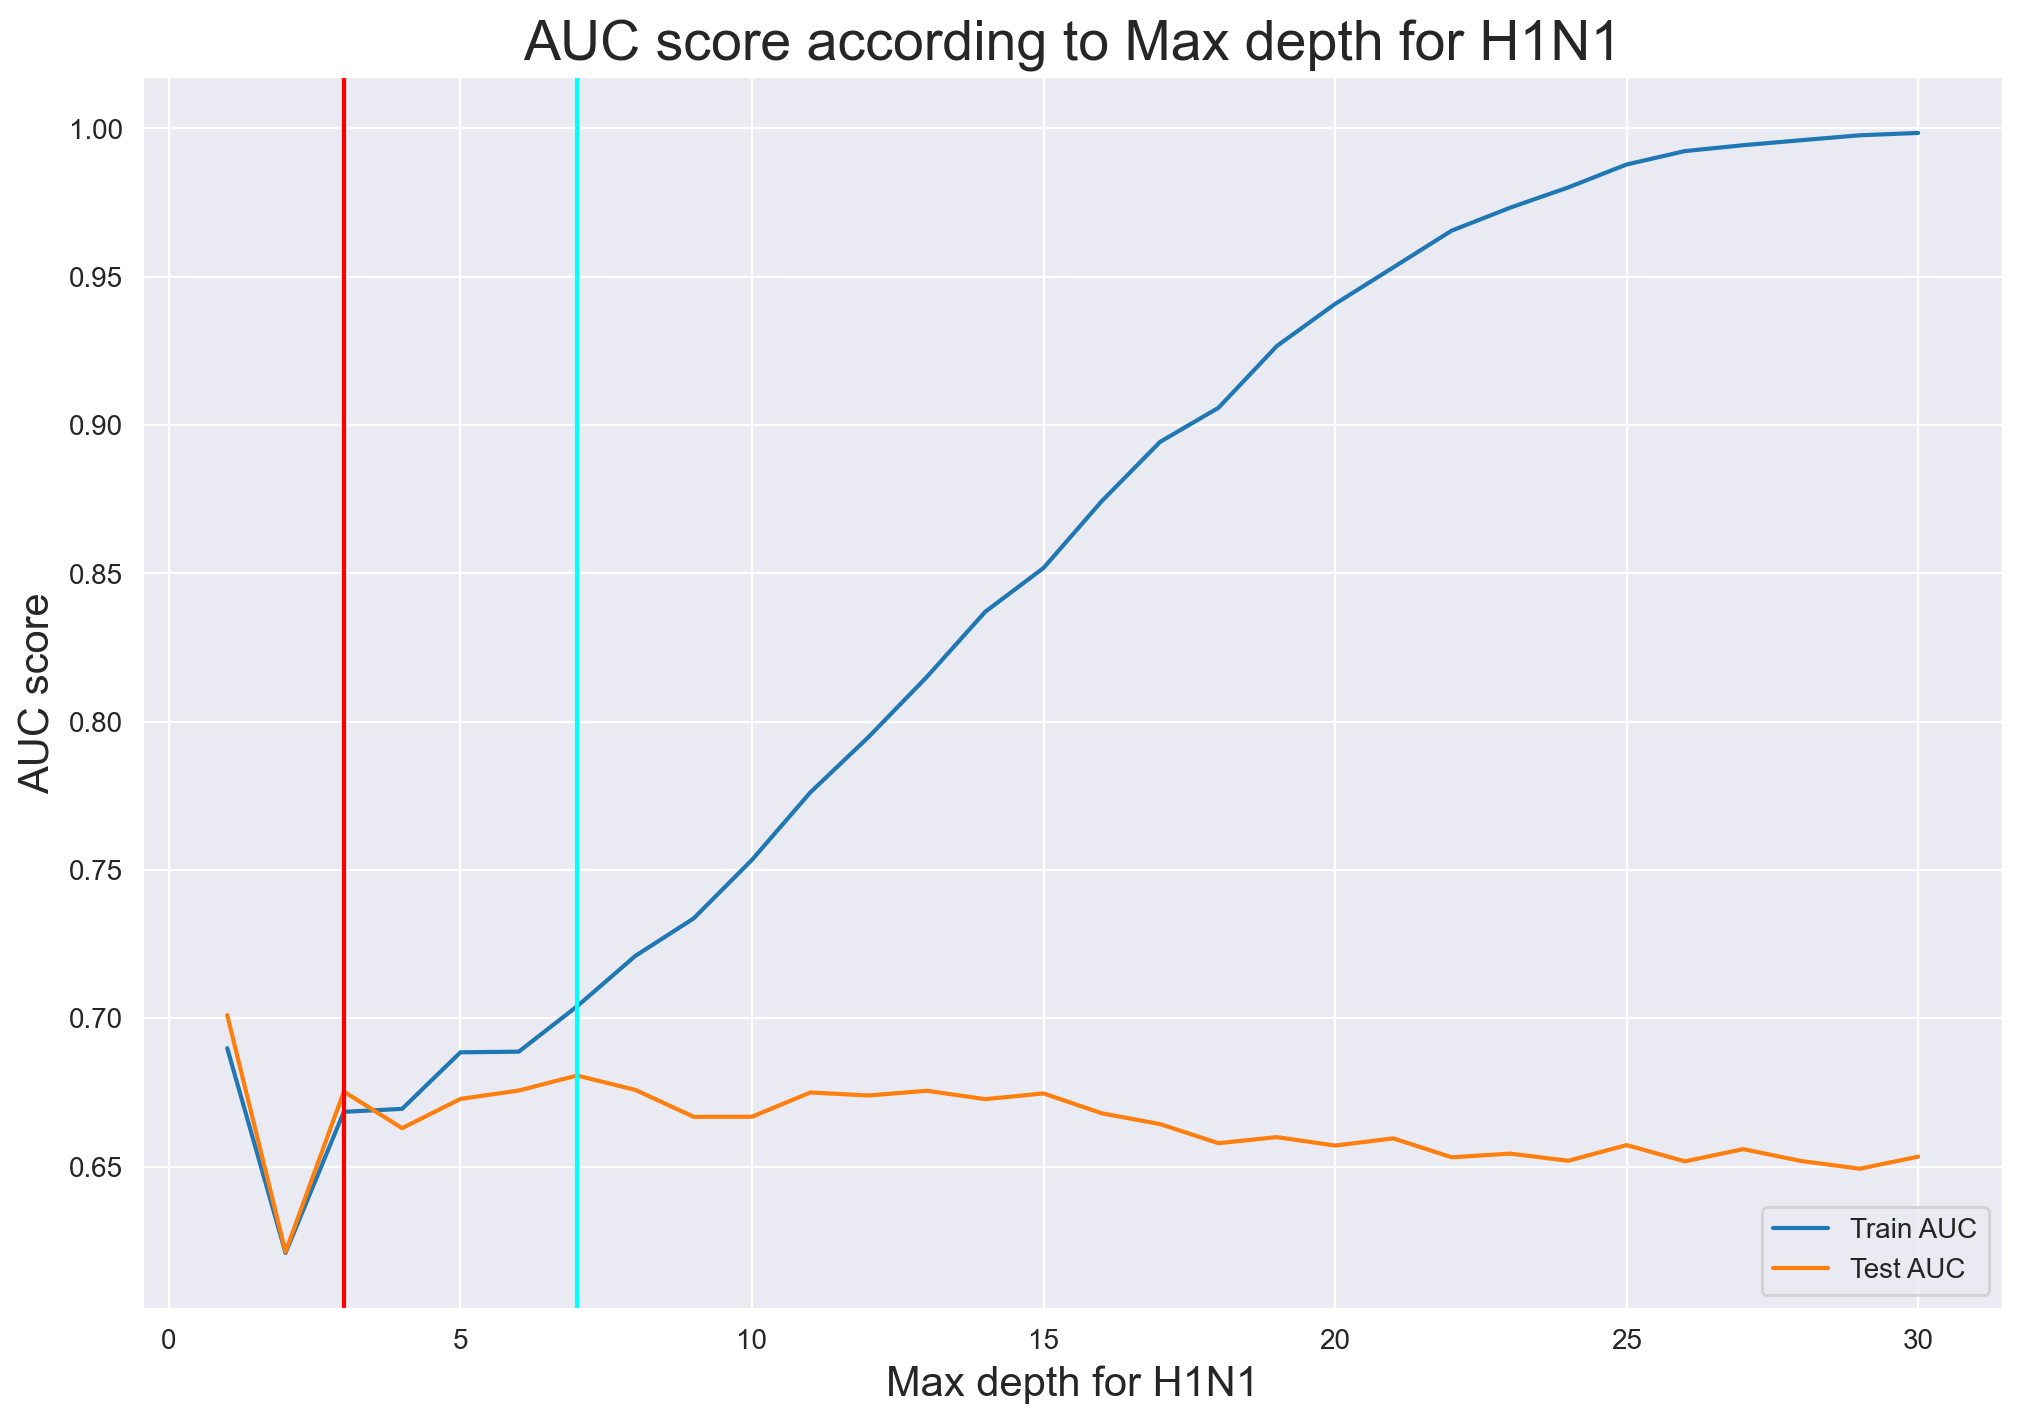

In [40]:
graph_auc(max_depths, train_results, test_results, min_x=3, max_x=7, hyperparameter='Max depth for H1N1')

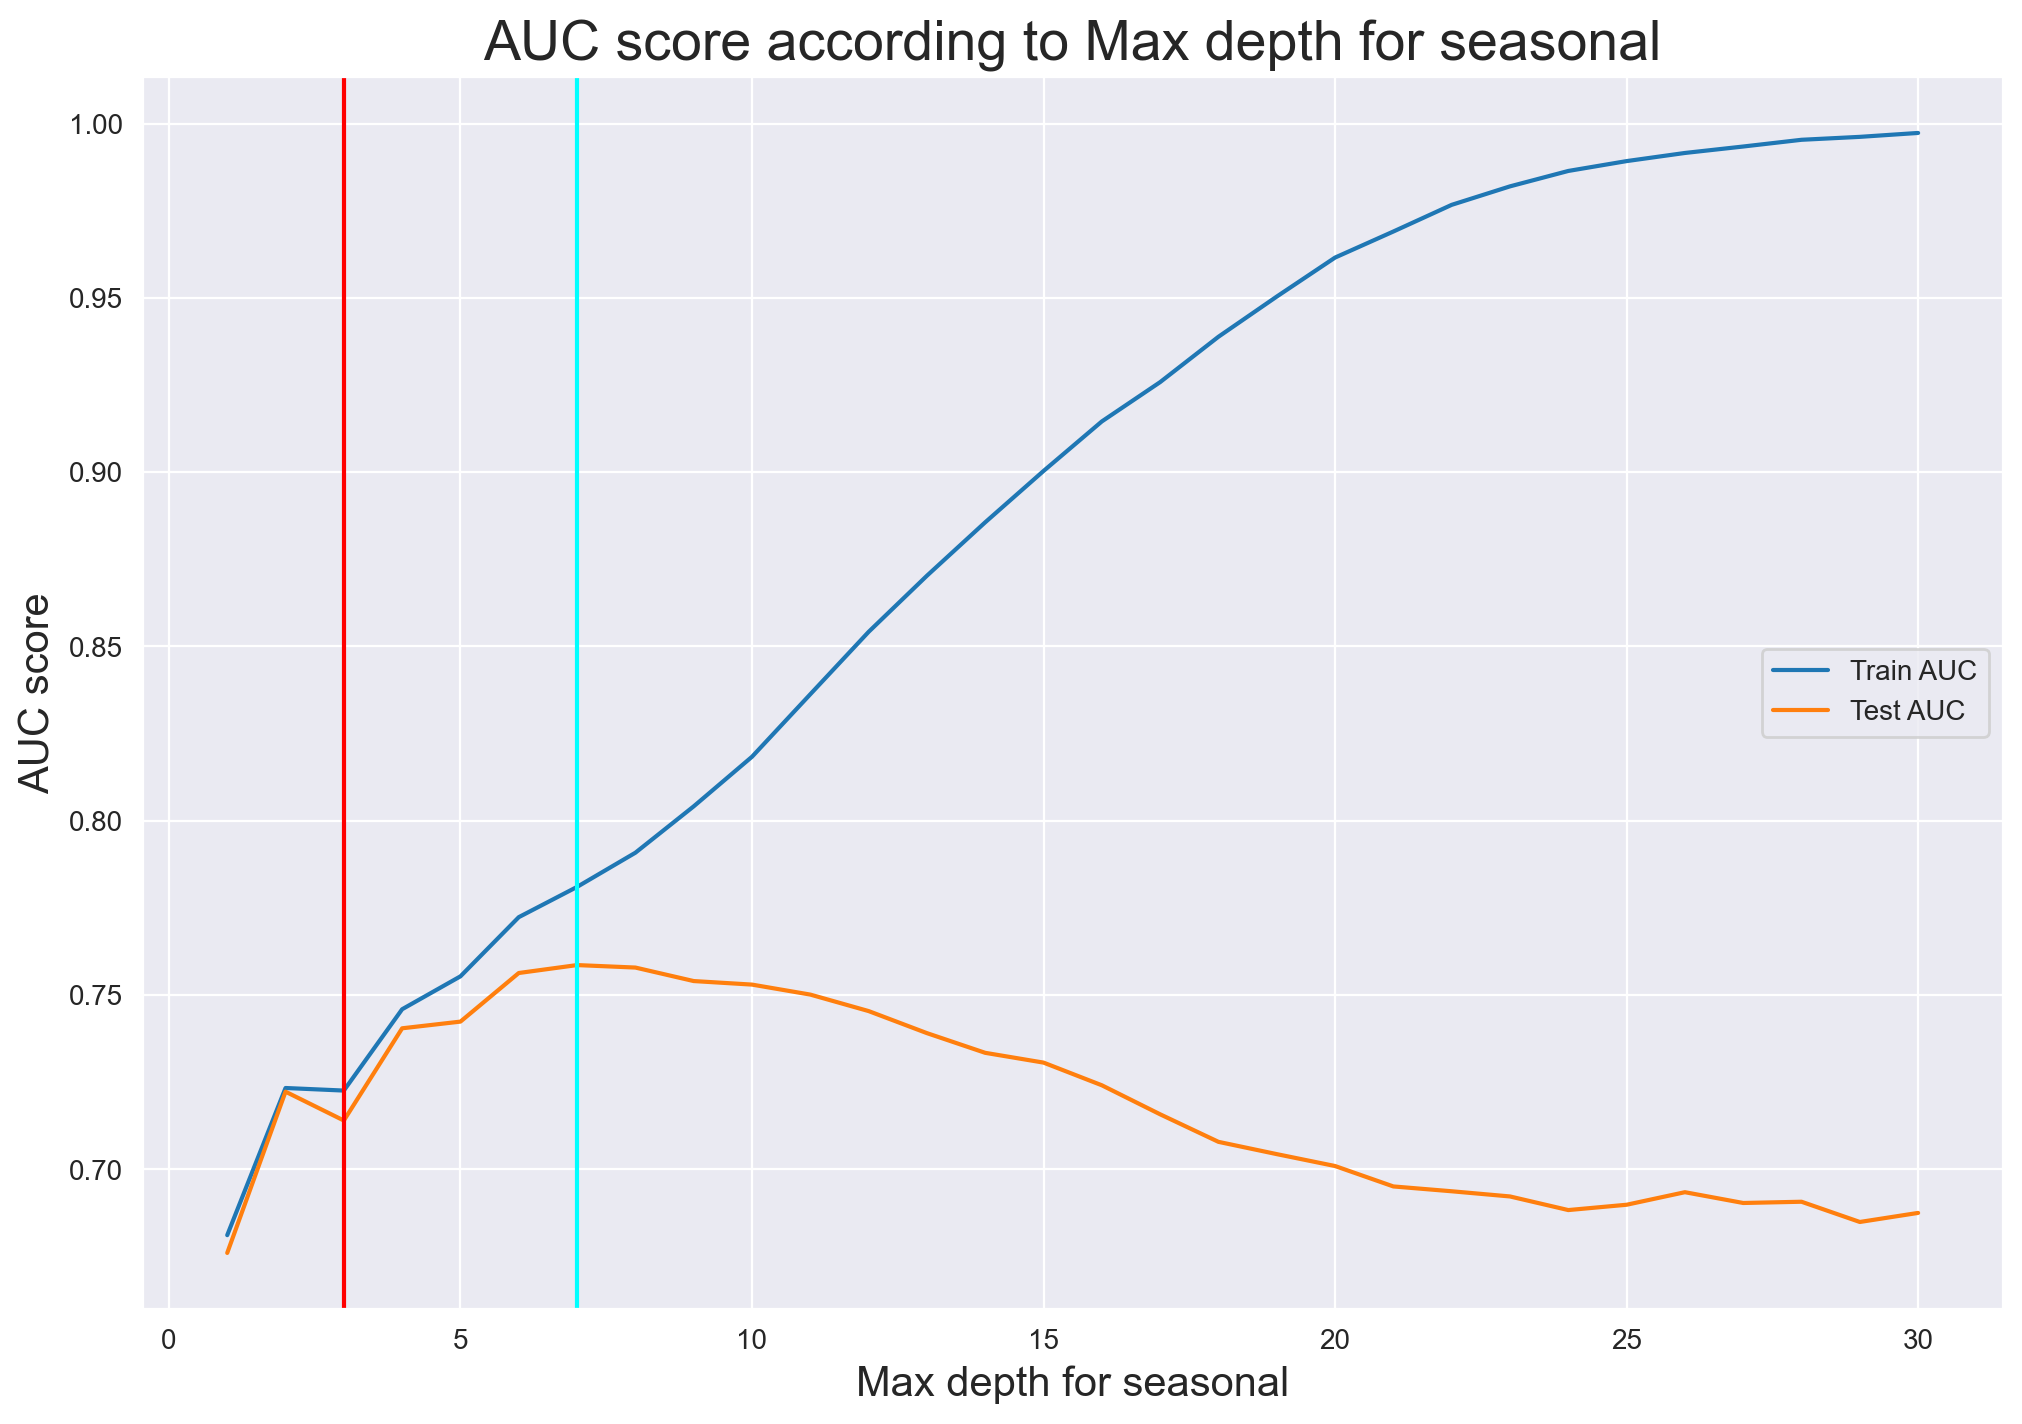

In [41]:
graph_auc(max_depths, train_results_seasonal, test_results_seasonal, min_x=3, max_x=7, hyperparameter='Max depth for seasonal')

It seems that a `max_depth` of 4 to 6 is optimal as the curves are not too spread apart and in between the two vertical lines indicating the lower log loss. A `max_depth=4` for the h1n1 model and `max_depth=5` will be used as it has the lowest cost and relatively similar AUC scores when compared to other max depths.
### Min sample splits
This hyperparameter splits an internal node after a minimum number of samples. This can either be an integer or float. If it is a float, it splits after a fraction of the total samples.
The procedure in finding the optimal value will be the same as the method for `max_depth`.

In [42]:
min_sample_splits = np.linspace(0.1, 1, num=19)

train_results_splits = []
test_results_splits = []
average_log_loss_min_sample_split=[]

for i in min_sample_splits:
    estimator = DecisionTreeClassifier(random_state=42, min_samples_split=i)
    
    dt = pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1)
    
    dt_log_loss = cross_val_score(dt, X_train_h1n1, y_train_h1n1, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_min_sample_split.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_h1n1)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_h1n1, y_hat_train)
    train_results_splits.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_h1n1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_h1n1, y_hat_test)
    test_results_splits.append(auc(false_positive_rate, true_positive_rate))

In [43]:
train_results_splits_seasonal = []
test_results_splits_seasonal = []
average_log_loss_min_sample_split_seasonal=[]

for i in min_sample_splits:
    estimator = DecisionTreeClassifier(random_state=42, min_samples_split=i)
    
    dt = pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal)
    
    dt_log_loss = cross_val_score(dt, X_train_seasonal, y_train_seasonal, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_min_sample_split_seasonal.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_seasonal)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_seasonal, y_hat_train)
    train_results_splits_seasonal.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_seasonal)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_seasonal, y_hat_test)
    test_results_splits_seasonal.append(auc(false_positive_rate, true_positive_rate))

In [44]:
for e in zip(min_sample_splits, average_log_loss_min_sample_split):
    print(e)

(0.1, 0.40440801293486883)
(0.15000000000000002, 0.40682878946260176)
(0.2, 0.41420249803698006)
(0.25, 0.4210789402119722)
(0.30000000000000004, 0.4215346584024098)
(0.35, 0.4219063617996297)
(0.4, 0.42216684903483126)
(0.45000000000000007, 0.42216684903483126)
(0.5, 0.4226957006636279)
(0.55, 0.4246098193892016)
(0.6, 0.4246098193892016)
(0.65, 0.43094485482661177)
(0.7000000000000001, 0.43094485482661177)
(0.75, 0.43094485482661177)
(0.8, 0.44266728166193536)
(0.85, 0.45215701552998205)
(0.9, 0.45215701552998205)
(0.9500000000000001, 0.45215701552998205)
(1.0, 0.45215701552998205)


In [45]:
for e in zip(min_sample_splits, average_log_loss_min_sample_split_seasonal):
    print(e)

(0.1, 0.5183390113629618)
(0.15000000000000002, 0.5324741783523251)
(0.2, 0.5393559422337562)
(0.25, 0.5497358913737811)
(0.30000000000000004, 0.5531706791952735)
(0.35, 0.5531706791952735)
(0.4, 0.5687962014679362)
(0.45000000000000007, 0.5742785145320506)
(0.5, 0.5915270950248976)
(0.55, 0.5915270950248976)
(0.6, 0.6026286935080416)
(0.65, 0.6237356538192664)
(0.7000000000000001, 0.6237356538192664)
(0.75, 0.6237356538192664)
(0.8, 0.6237356538192664)
(0.85, 0.6237356538192664)
(0.9, 0.6237356538192664)
(0.9500000000000001, 0.6237356538192664)
(1.0, 0.6237356538192664)


Because `min_samples_split` are floats, the `average_log_loss_list()` function does not work. Instead, a for loop is used to print out tuples with their corresponding values. According to both the H1N1 and seasonal data, the lowest loss of function occurs at 0.1 but the AUC score may be low. We can look at values between 0.1 and 0.4 as the fractional splits have relatively low loss.

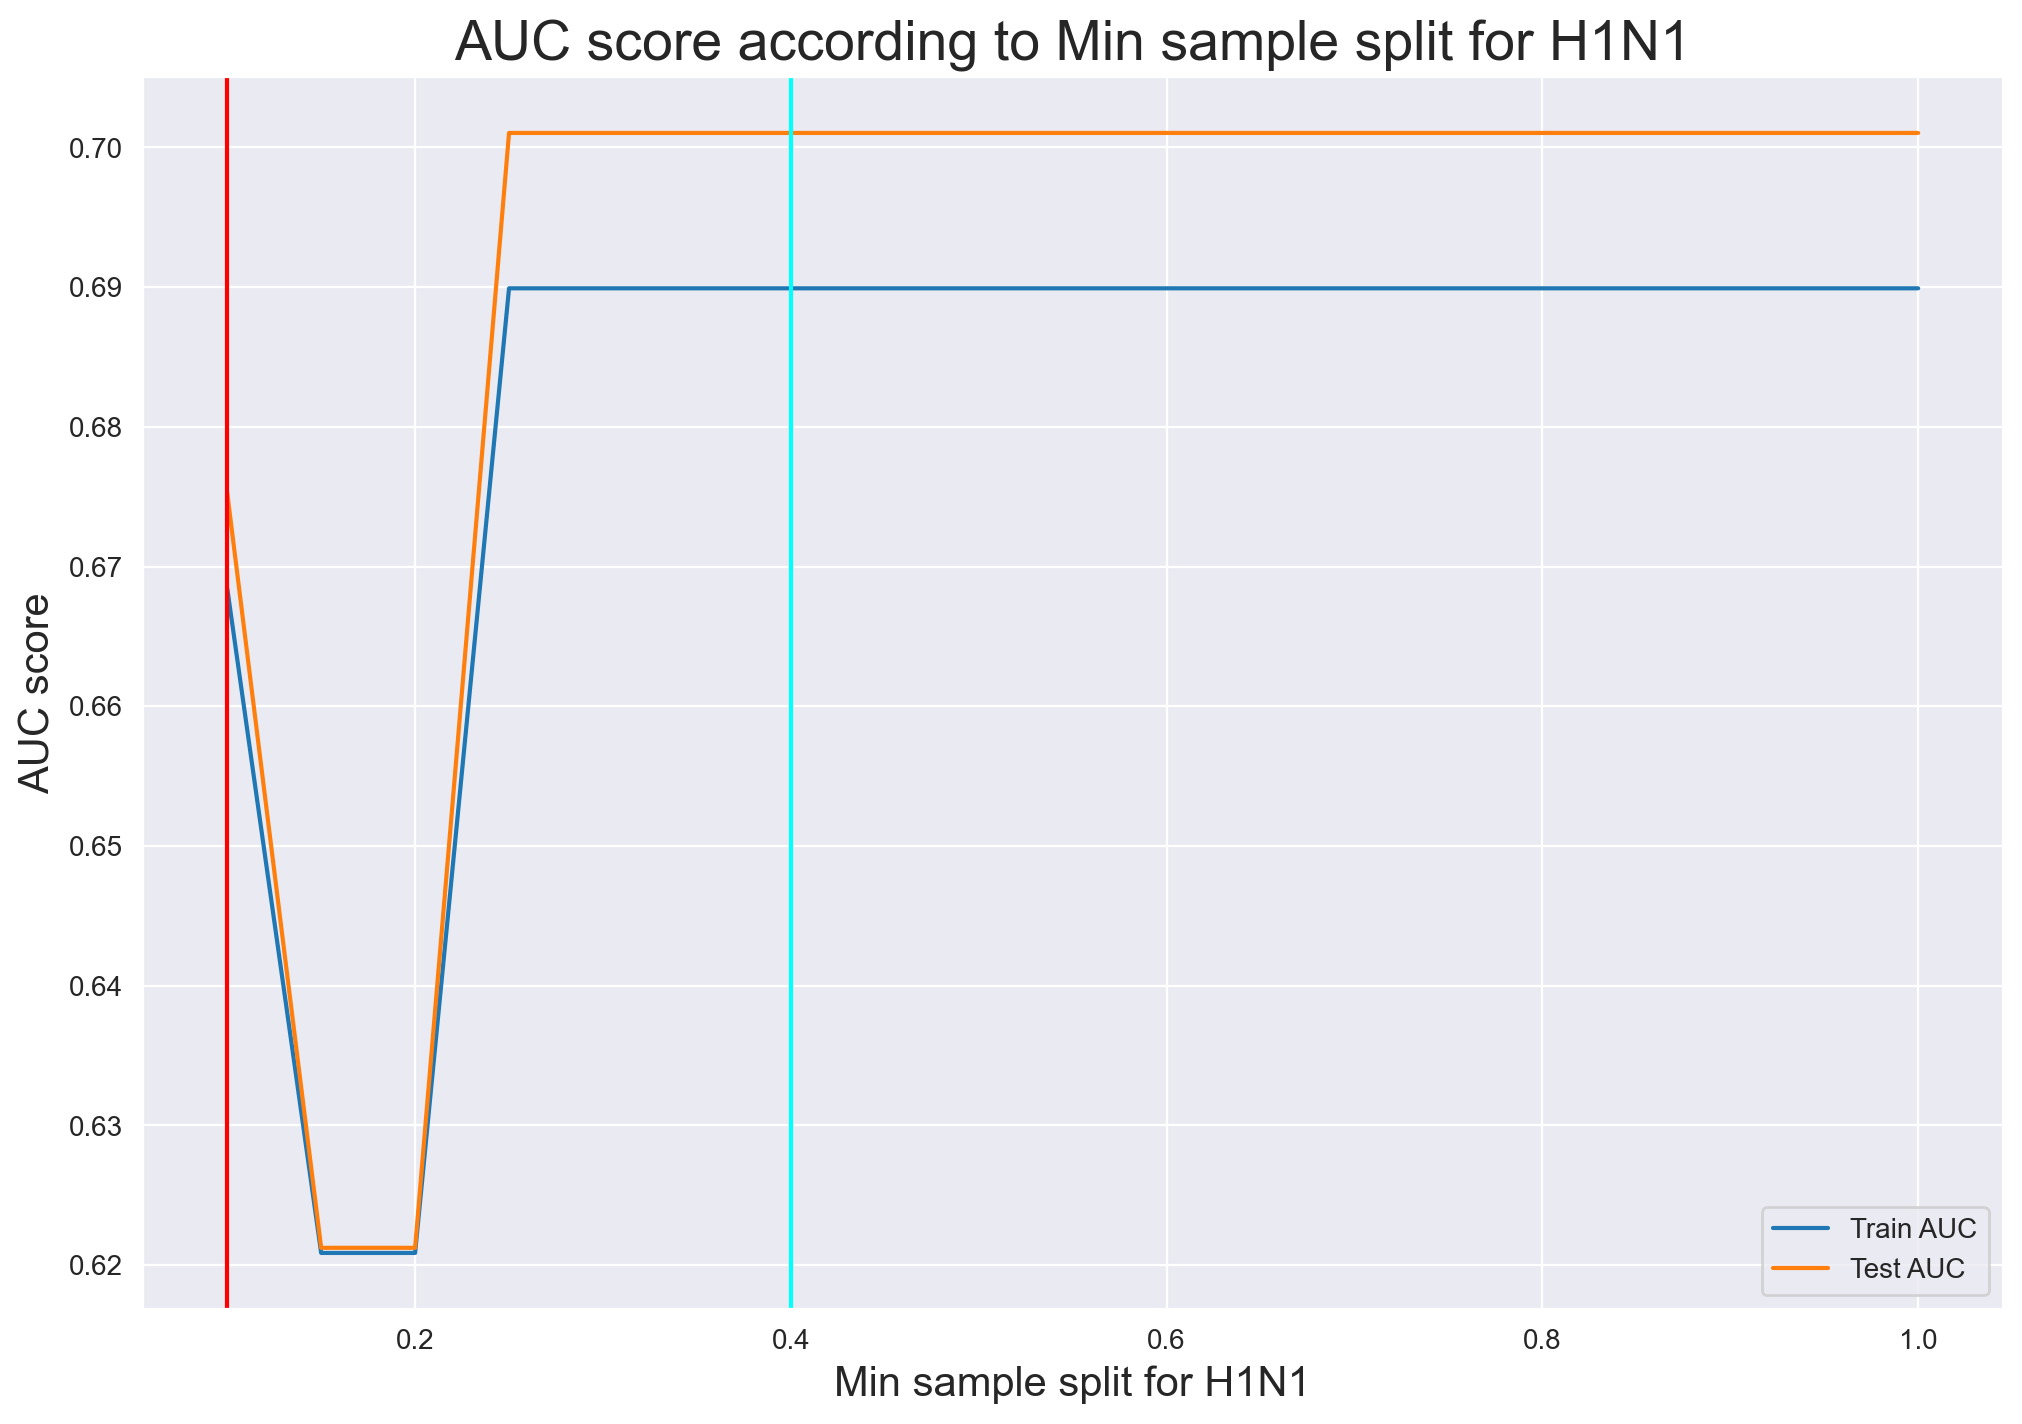

In [46]:
graph_auc(min_sample_splits, train_results_splits, test_results_splits, min_x=0.1, max_x=0.4, hyperparameter='Min sample split for H1N1')

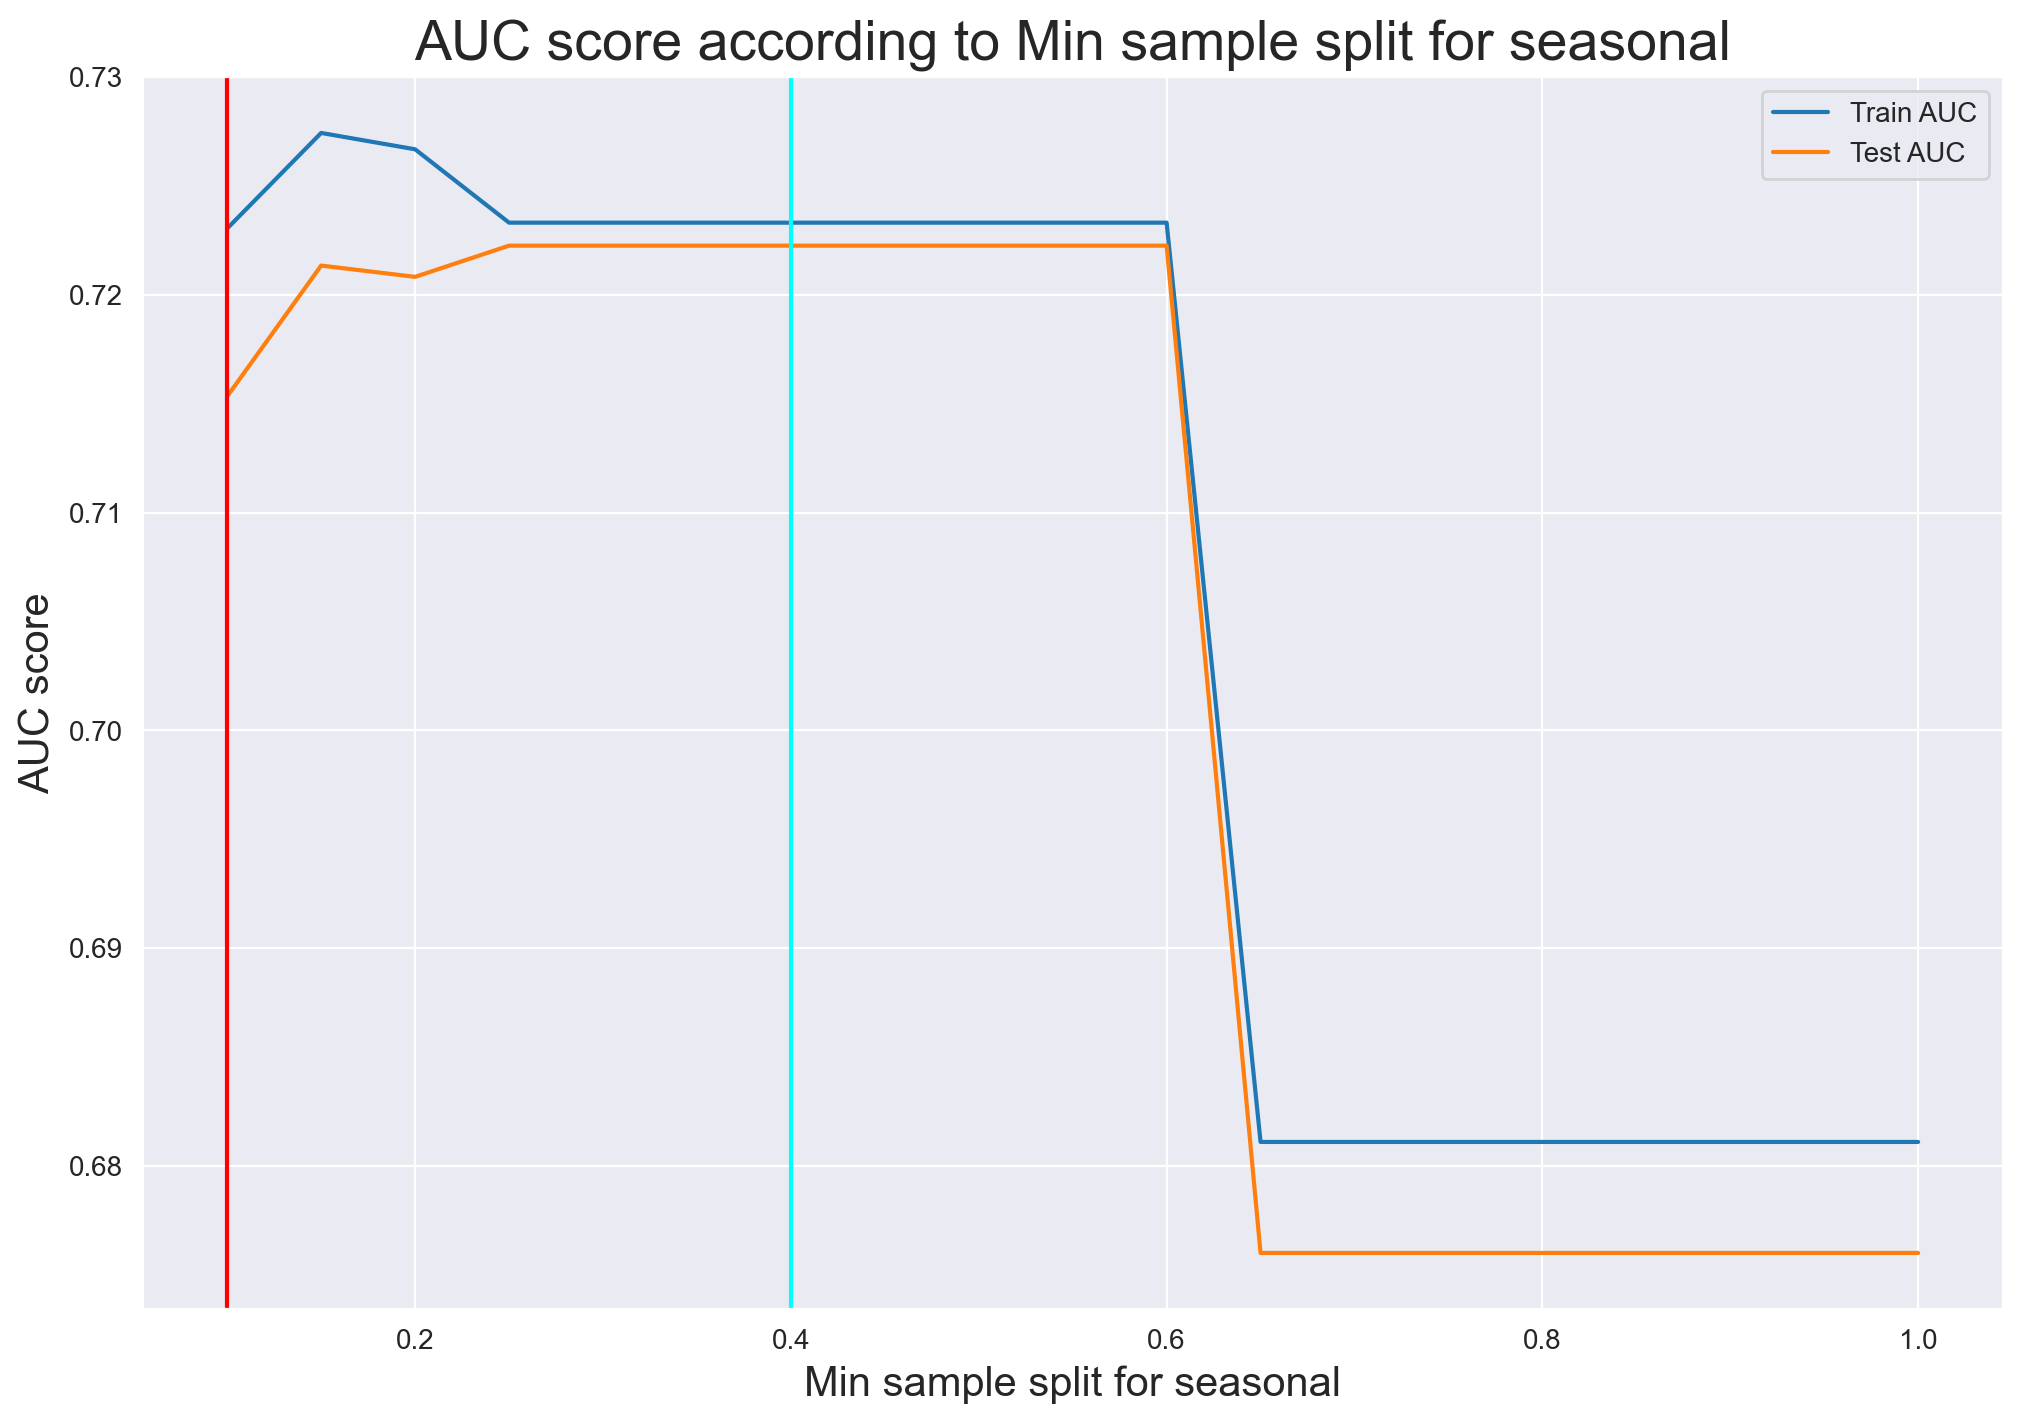

In [47]:
graph_auc(min_sample_splits, train_results_splits_seasonal, test_results_splits_seasonal, min_x=0.1, max_x=0.4, hyperparameter='Min sample split for seasonal')

According to the H1N1 dataset, the AUC score for 0.1 split is lower than a split of 0.3 and onward. Although the train and test AUC are closer together, I chose a split fraction of 0.1 just because of the lower cost and the AUC scores is only a few hundredth off compared to 0.3.
As for the seasonal dataset, the AUC score is greatest for a split of 0.1. Although the gap between the train and test set is bigger, it is not as big and a 0.1 split returns a lower log loss value.
### Min sample leafs
This hyperparameter determines the minimum number of samples allowed in a leaf node. If a leaf node does not have enough samples in each of the left and right branch, the split does not occur.

In [48]:
min_samples_leafs = list(range(120,170))

train_results_leafs = []
test_results_leafs = []
average_log_loss_min_sample_leafs=[]
for i in min_samples_leafs:
    estimator = DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
    
    dt = pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1)
    
    dt_log_loss = cross_val_score(dt, X_train_h1n1, y_train_h1n1, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_min_sample_leafs.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_h1n1)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_h1n1, y_hat_train)
    train_results_leafs.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_h1n1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_h1n1, y_hat_test)
    test_results_leafs.append(auc(false_positive_rate, true_positive_rate))

In [49]:
min_samples_leafs = list(range(120,170))

train_results_leafs_seasonal = []
test_results_leafs_seasonal = []
average_log_loss_min_sample_leafs_seasonal=[]
for i in min_samples_leafs:
    estimator = DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
    
    dt = pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal)
    
    dt_log_loss = cross_val_score(dt, X_train_seasonal, y_train_seasonal, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_min_sample_leafs_seasonal.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_seasonal)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_seasonal, y_hat_train)
    train_results_leafs_seasonal.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_seasonal)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_seasonal, y_hat_test)
    test_results_leafs_seasonal.append(auc(false_positive_rate, true_positive_rate))

In [50]:
average_log_loss_list(average_log_loss_min_sample_leafs, start=120)

[(120, 0.4243764828060267),
 (121, 0.42446733356934674),
 (122, 0.42337451786233105),
 (123, 0.42338703982378656),
 (124, 0.42323937878250784),
 (125, 0.4229679390438766),
 (126, 0.4215836982511469),
 (127, 0.4166015512518359),
 (128, 0.41670899220233676),
 (129, 0.42533658882826586),
 (130, 0.4251728617616844),
 (131, 0.4255942560187342),
 (132, 0.41705864144424964),
 (133, 0.41679813960434364),
 (134, 0.41689143742880097),
 (135, 0.41683696482571453),
 (136, 0.4167612631374264),
 (137, 0.4134385287811817),
 (138, 0.41001308767177713),
 (139, 0.40864721365017304),
 (140, 0.4085090961895048),
 (141, 0.4086885743208383),
 (142, 0.40876208020520377),
 (143, 0.40871053983004585),
 (144, 0.4084381412050545),
 (145, 0.40803372910873026),
 (146, 0.40797206415528403),
 (147, 0.4079968766386924),
 (148, 0.40791882808507396),
 (149, 0.40785660850352834),
 (150, 0.40613913838804844),
 (151, 0.40615961267947726),
 (152, 0.40632801551782444),
 (153, 0.40798916122011963),
 (154, 0.40628705650330926

In [51]:
average_log_loss_list(average_log_loss_min_sample_leafs_seasonal, start=120)

[(120, 0.5172806510154968),
 (121, 0.5172862471004129),
 (122, 0.517047921381354),
 (123, 0.5170988753140161),
 (124, 0.5168840966508037),
 (125, 0.5167918750702816),
 (126, 0.5164599195385435),
 (127, 0.5166026052578855),
 (128, 0.5166950831109843),
 (129, 0.5168416849383697),
 (130, 0.516512769347591),
 (131, 0.5167401698769529),
 (132, 0.516705399993799),
 (133, 0.5170194708242117),
 (134, 0.5170364970744435),
 (135, 0.5174062781672354),
 (136, 0.5173094430158081),
 (137, 0.5170085705283292),
 (138, 0.5171393192240046),
 (139, 0.5167815120380859),
 (140, 0.5082371288972102),
 (141, 0.5081989403769522),
 (142, 0.5046768617261255),
 (143, 0.5041377449362849),
 (144, 0.5042742587022744),
 (145, 0.5042734263287418),
 (146, 0.5042503253761016),
 (147, 0.5042442463258514),
 (148, 0.5047678495571983),
 (149, 0.5053585366160612),
 (150, 0.5051314125143958),
 (151, 0.5051753182190707),
 (152, 0.5048058756263459),
 (153, 0.5045679312187945),
 (154, 0.5043423427945589),
 (155, 0.50393282069807

For the H1N1 dataset lowest loss of function occurs when `min_samples_leafs` is 161 and 143 for the seasonal dataset.

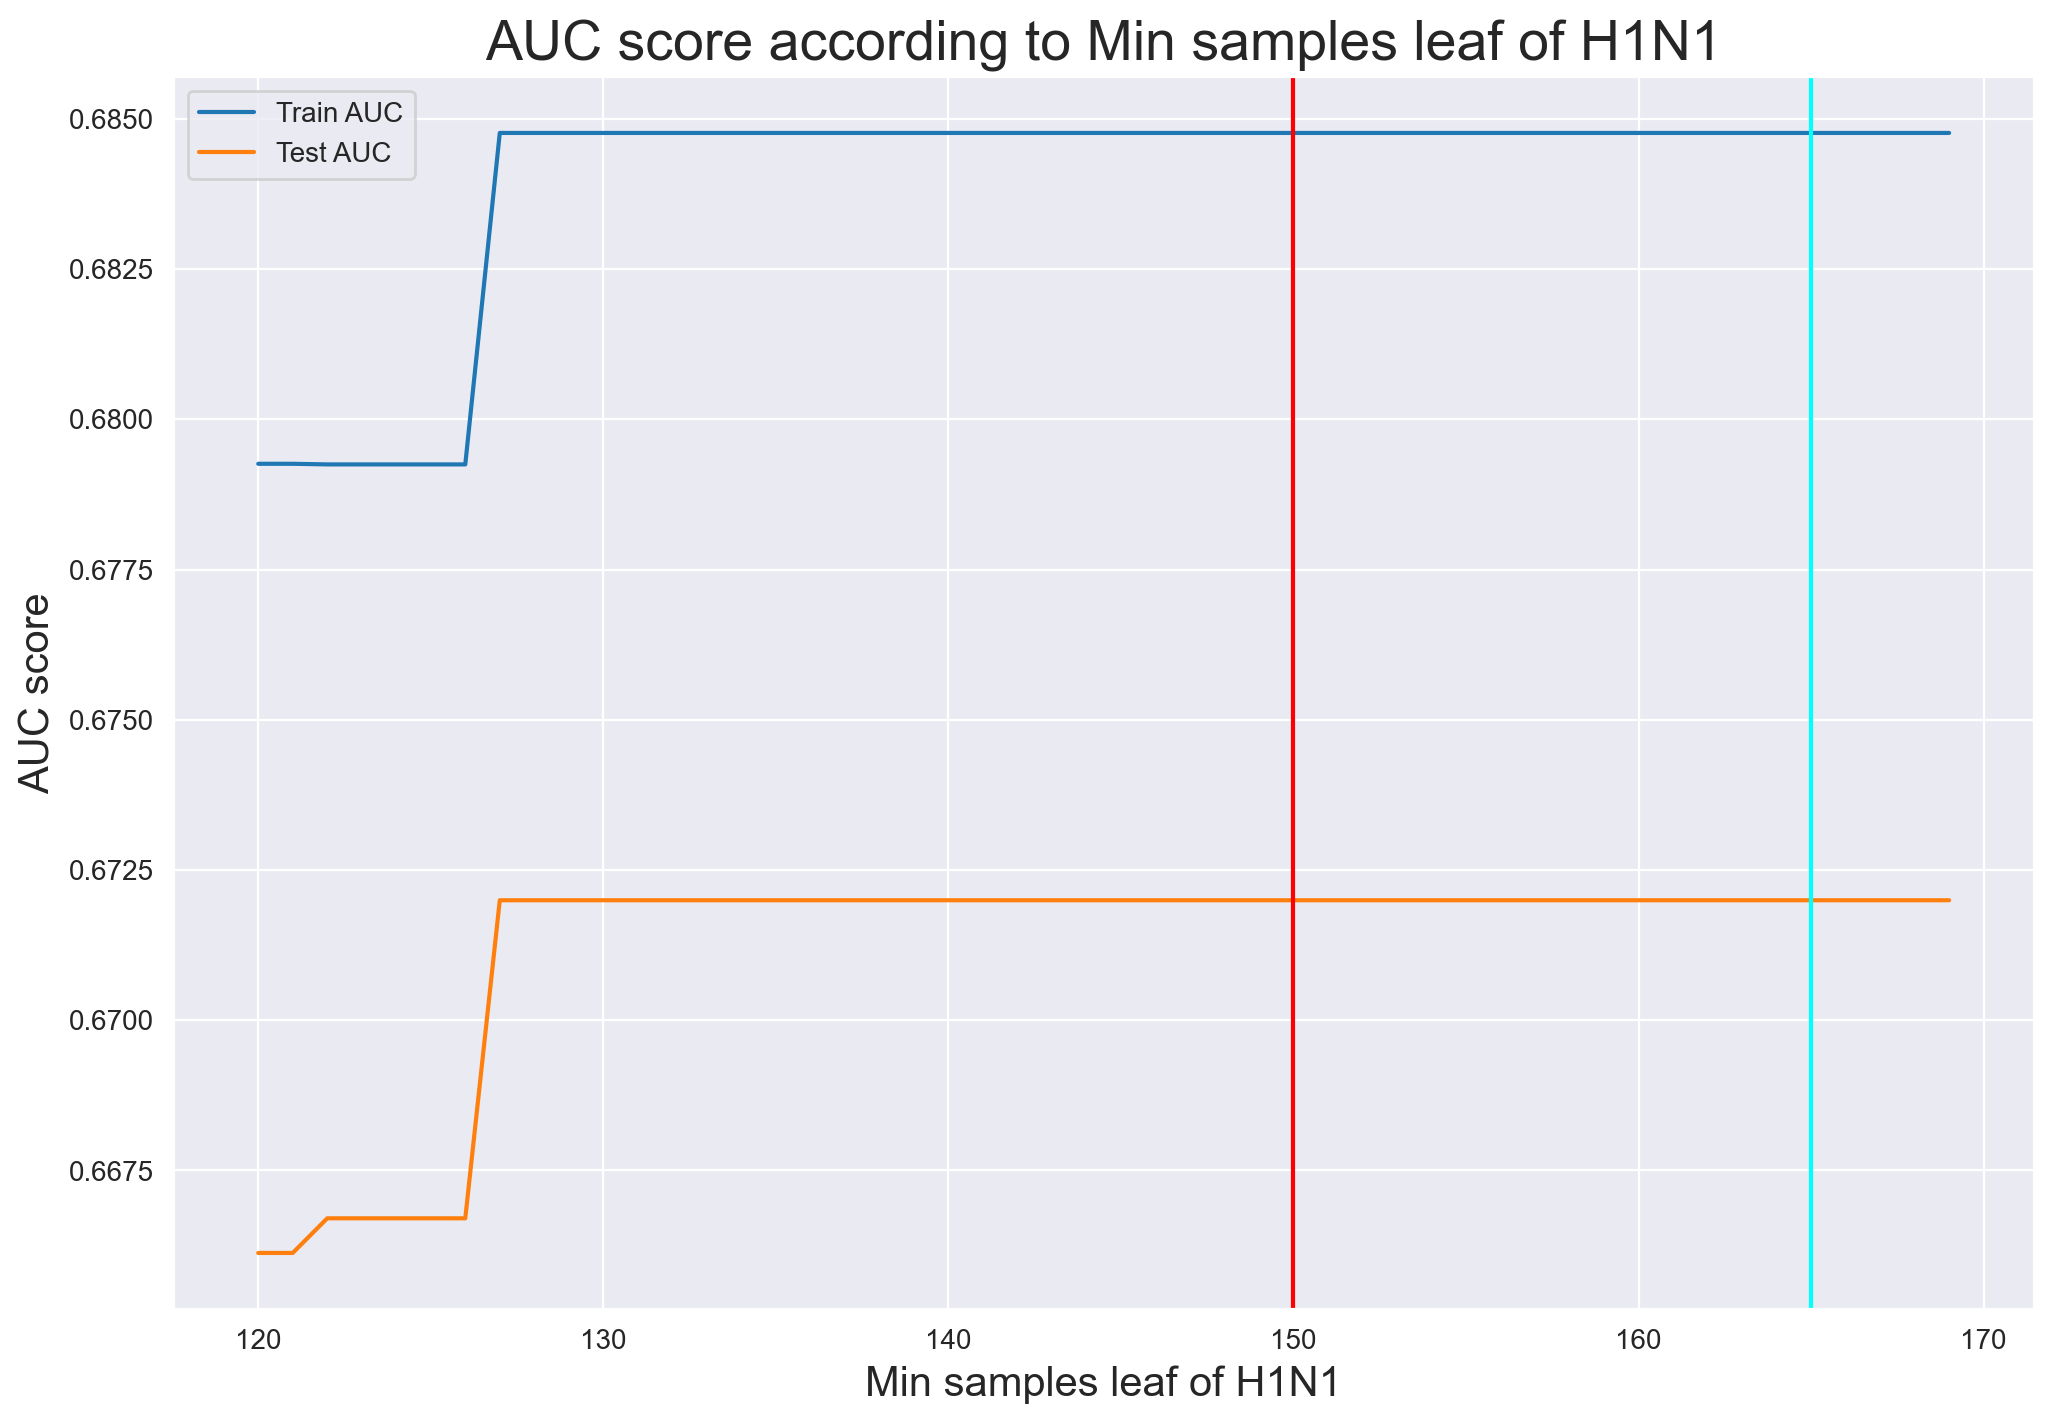

In [52]:
graph_auc(min_samples_leafs, train_results_leafs, test_results_leafs, min_x=150, max_x=165, hyperparameter='Min samples leaf of H1N1')

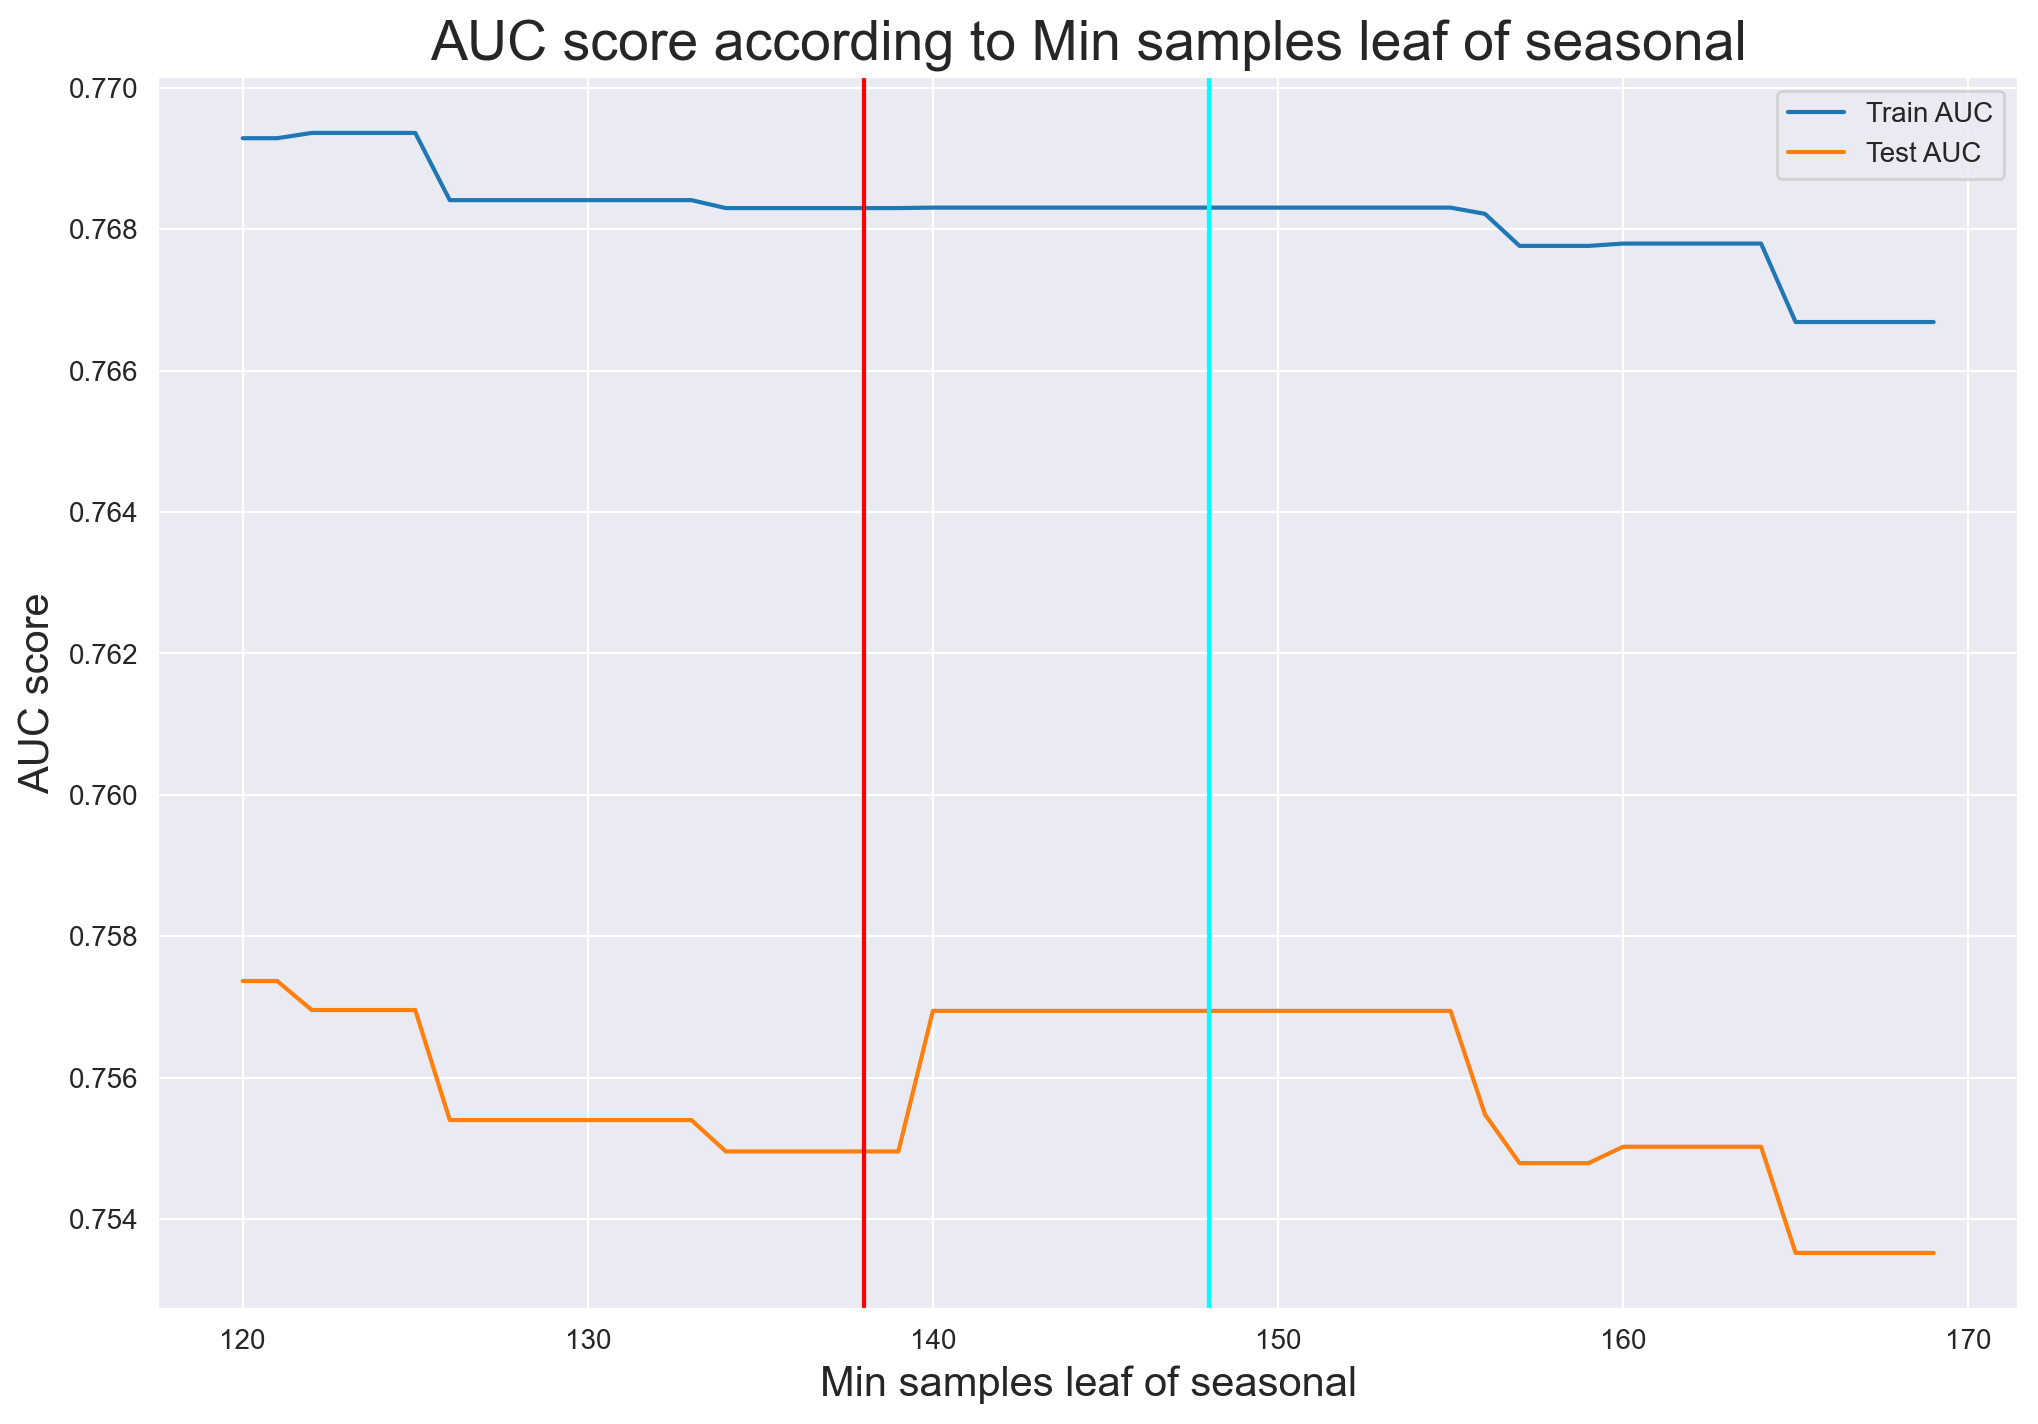

In [53]:
graph_auc(min_samples_leafs, train_results_leafs_seasonal, test_results_leafs_seasonal, min_x=138, max_x=148, hyperparameter='Min samples leaf of seasonal')

H1N1: From the graph the AUC score plateaus around 125 samples. So we will set `min_sample_leaf=161` as it has the samd AUC and the lowest loss.

Seasonal: The graph indicates a decreasing trend in AUC but it seems to be a very slow change. We can comfortably set the `min_sample_leaf=143`.
### Max leaf nodes
This hyperparameter limits the number of leaf nodes produced. Similar to `max_depth` it will control how deep the tree goes. The higher the number for `max_leaf_nodes` the deeper the tree.

In [54]:
max_leaf_nodes = list(range(15,35))

train_results = []
test_results = []
average_log_loss_max_leaf_node=[]
for i in max_leaf_nodes:
    estimator = DecisionTreeClassifier(random_state=42, max_leaf_nodes=int(i))
    
    dt = pipelines(X_train_h1n1, y_train_h1n1, num_col_h1n1, cat_col_h1n1)
    
    dt_log_loss = cross_val_score(dt, X_train_h1n1, y_train_h1n1, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_max_leaf_node.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_h1n1)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_h1n1, y_hat_train)
    train_results.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_h1n1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_h1n1, y_hat_test)
    test_results.append(auc(false_positive_rate, true_positive_rate))

In [55]:
max_leaf_nodes_seasonal = list(range(35,55))

train_results_seasonal = []
test_results_seasonal = []
average_log_loss_max_leaf_node_seasonal=[]
for i in max_leaf_nodes_seasonal:
    estimator = DecisionTreeClassifier(random_state=42, max_leaf_nodes=int(i))
    
    dt = pipelines(X_train_seasonal, y_train_seasonal, num_col_seasonal, cat_col_seasonal)
    
    dt_log_loss = cross_val_score(dt, X_train_seasonal, y_train_seasonal, scoring='neg_log_loss')
    dt_log_loss_avg = -np.average(dt_log_loss)
    average_log_loss_max_leaf_node_seasonal.append(dt_log_loss_avg)
    
    y_hat_train = dt.predict(X_train_seasonal)
    false_positive_rate_train, true_positive_rate_train, thresholds = roc_curve(y_train_seasonal, y_hat_train)
    train_results_seasonal.append(auc(false_positive_rate_train, true_positive_rate_train))
    
    y_hat_test = dt.predict(X_test_seasonal)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_seasonal, y_hat_test)
    test_results_seasonal.append(auc(false_positive_rate, true_positive_rate))

In [56]:
average_log_loss_list(average_log_loss_max_leaf_node, start=15)

[(15, 0.3992653161912416),
 (16, 0.39824418539437545),
 (17, 0.3975712137649641),
 (18, 0.3993635130113138),
 (19, 0.39917007783737707),
 (20, 0.3991981097438647),
 (21, 0.40055807781500474),
 (22, 0.3997202981380832),
 (23, 0.3990516776174883),
 (24, 0.398696766300047),
 (25, 0.39863914145231494),
 (26, 0.3987750304346927),
 (27, 0.399052271388185),
 (28, 0.3998916133067318),
 (29, 0.39970767314168654),
 (30, 0.39972010667610236),
 (31, 0.4038330001405569),
 (32, 0.40343939304613796),
 (33, 0.40333729484440745),
 (34, 0.40364782916266917)]

In [57]:
average_log_loss_list(average_log_loss_max_leaf_node_seasonal, start=35)

[(35, 0.5059701085257027),
 (36, 0.5059913743635323),
 (37, 0.5057144708774748),
 (38, 0.5054977887320857),
 (39, 0.5052259671445788),
 (40, 0.5051071372462832),
 (41, 0.5050446090410601),
 (42, 0.5051452353608142),
 (43, 0.5051244217401648),
 (44, 0.5051410285456376),
 (45, 0.504897447060084),
 (46, 0.5046573282418325),
 (47, 0.5059851045041015),
 (48, 0.5057540167202397),
 (49, 0.5055463257987421),
 (50, 0.5050916418675889),
 (51, 0.505405983724257),
 (52, 0.5131192890792408),
 (53, 0.5128111990091898),
 (54, 0.5160197203670516)]

H1N1: The lowest loss occurs when `max_leaf_nodes=17`.

Seasonal: Lowest loss occurs when `max_leaf_nodes=41`.

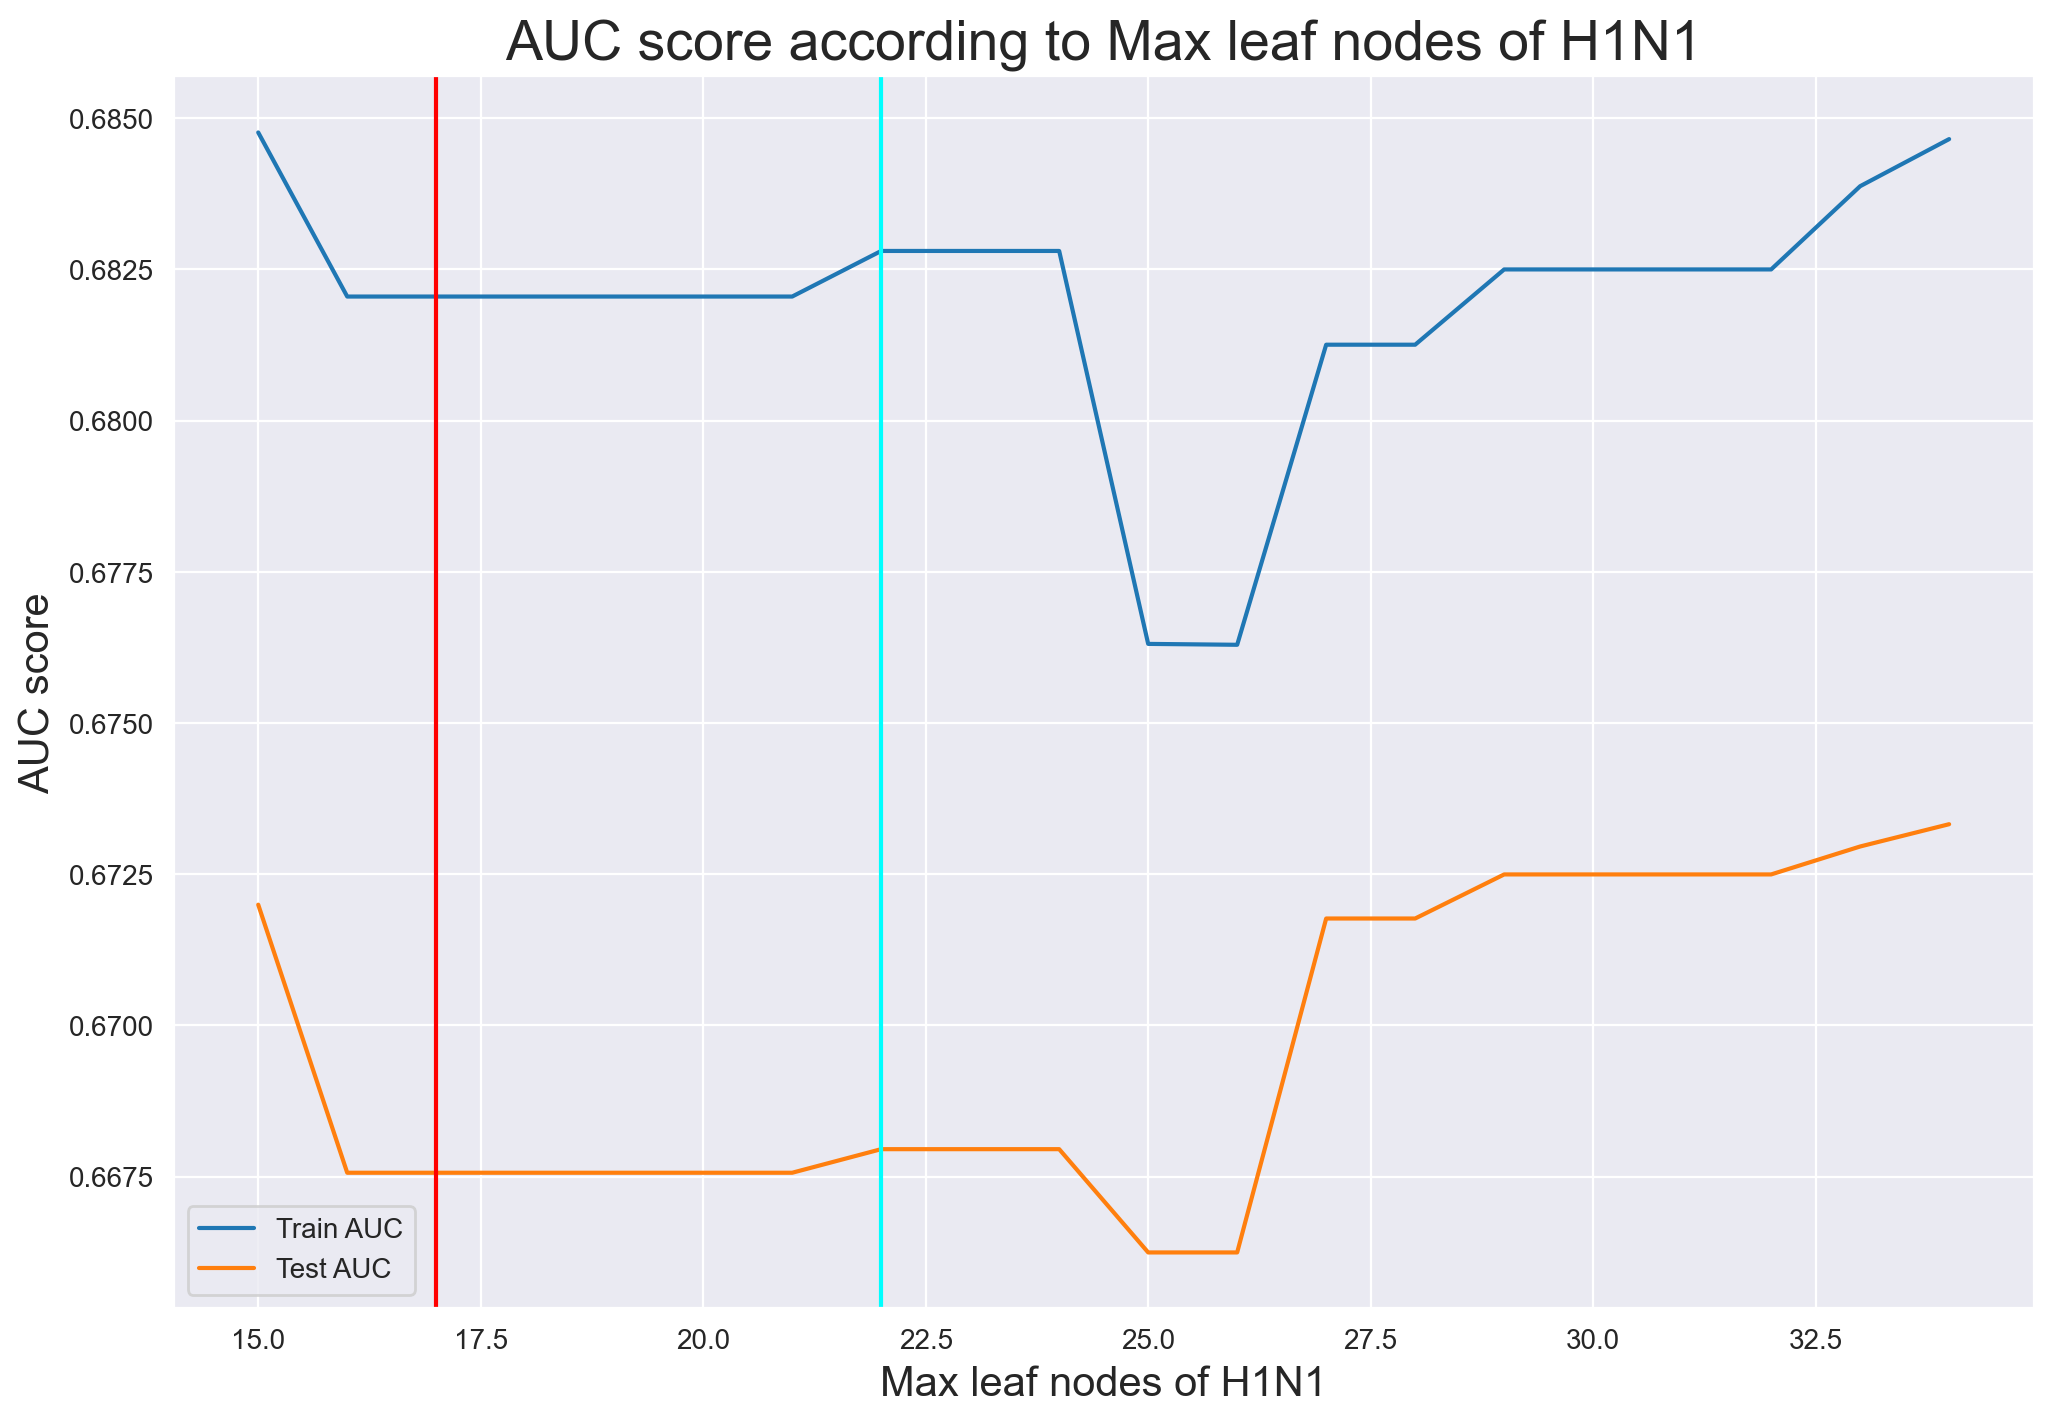

In [58]:
graph_auc(max_leaf_nodes, train_results, test_results, min_x=17, max_x=22, hyperparameter='Max leaf nodes of H1N1')

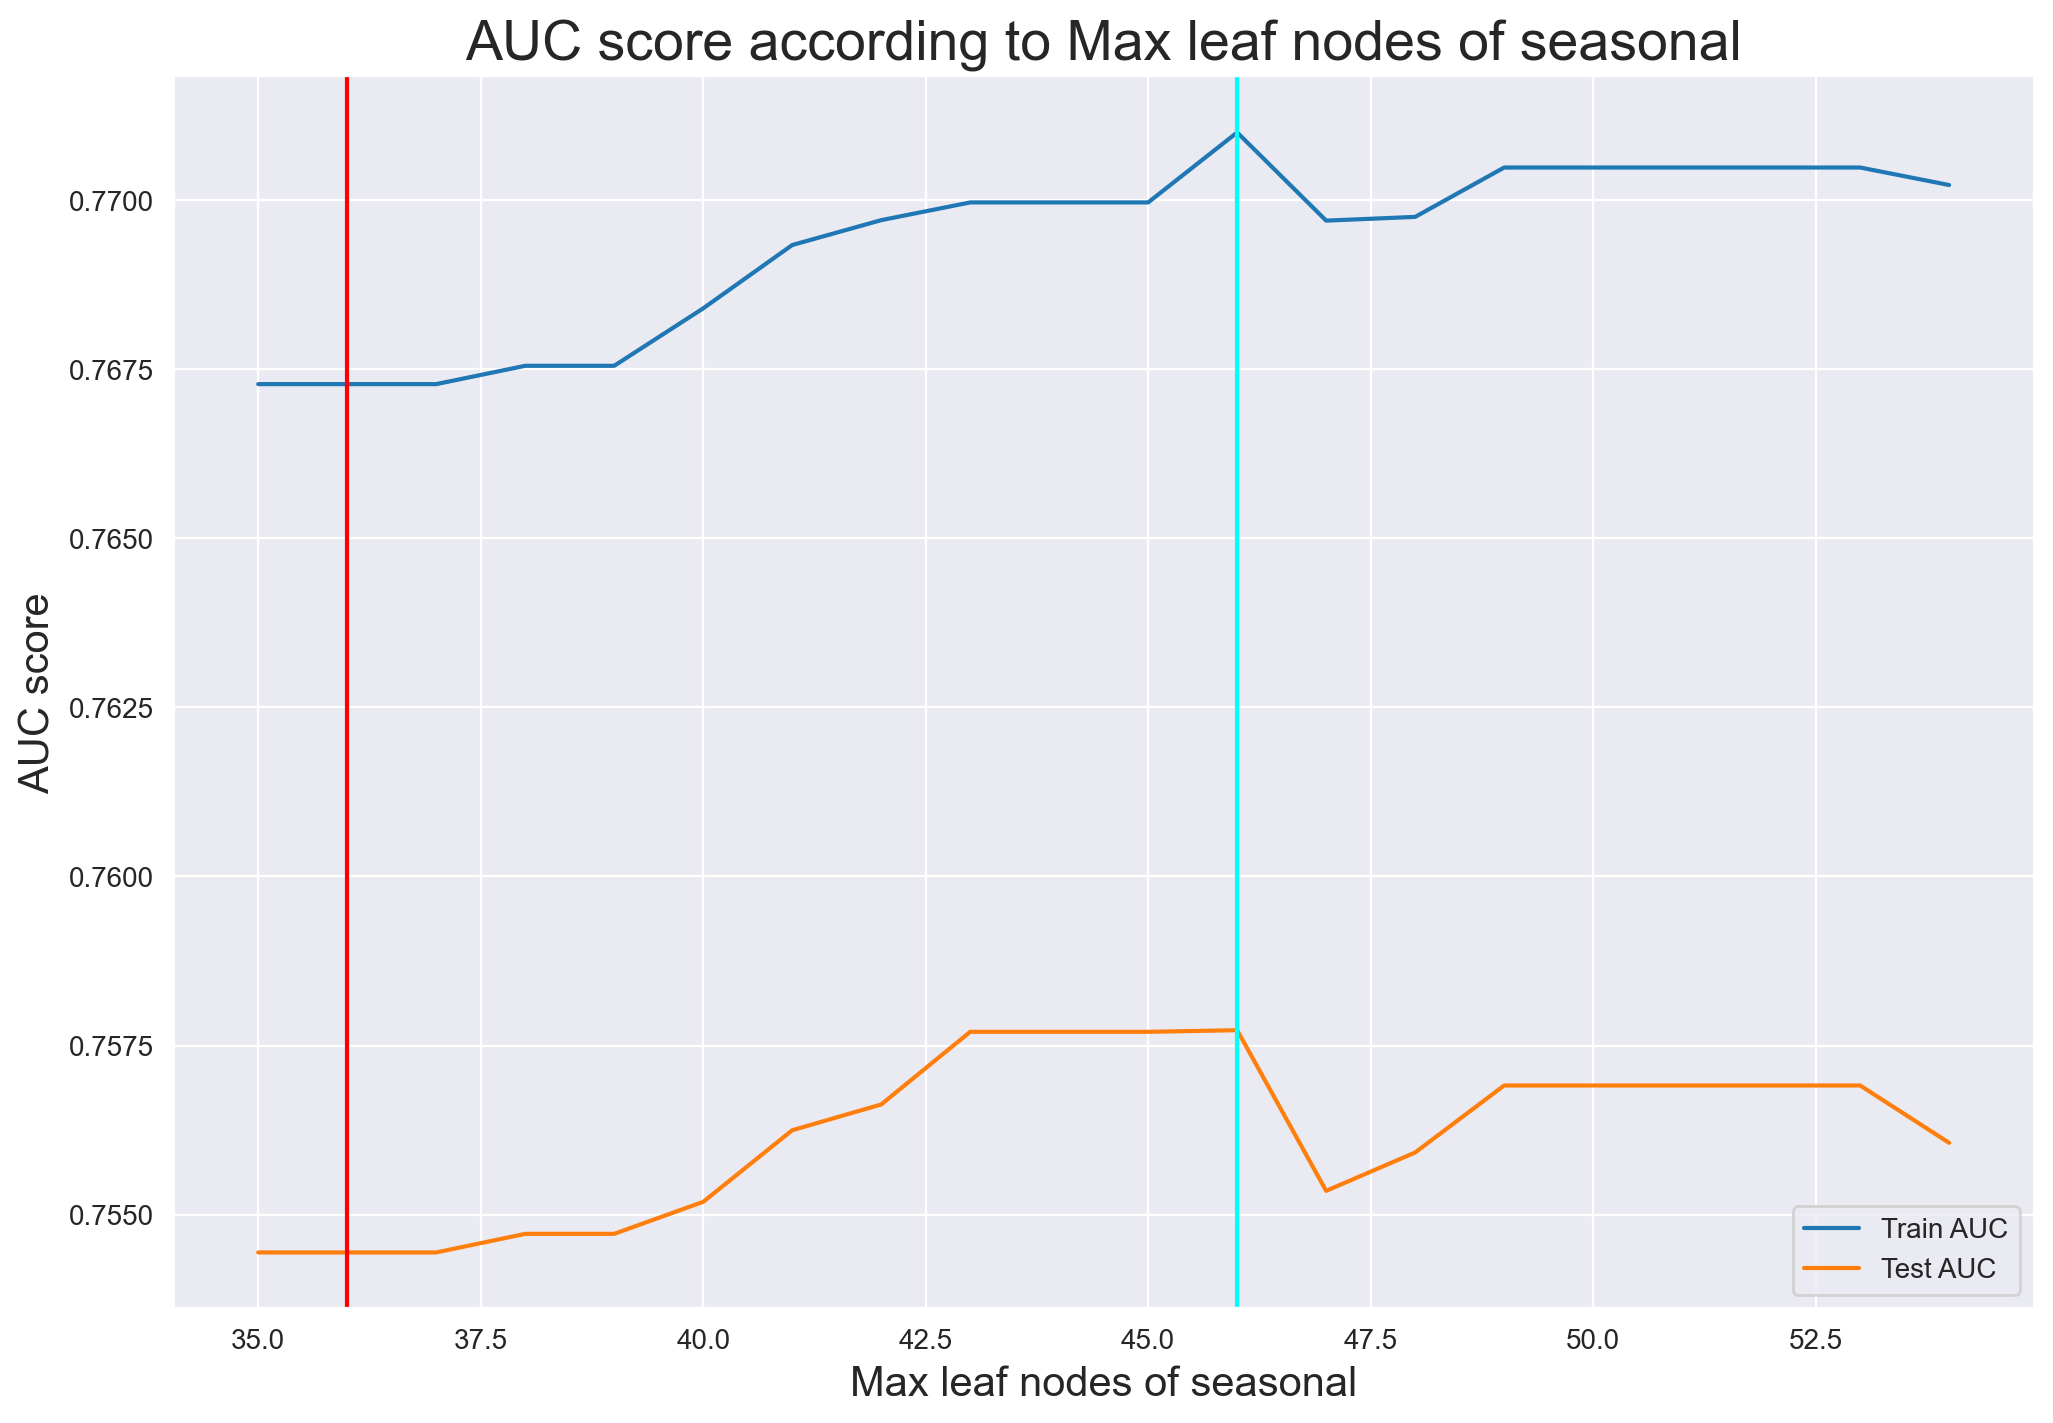

In [59]:
graph_auc(max_leaf_nodes_seasonal, train_results_seasonal, test_results_seasonal, min_x=36, max_x=46, hyperparameter='Max leaf nodes of seasonal')

H1N1: According to the graph, the lowest AUC score for both the train and test set occurs at 25. And although the AUC score does increase afterwards, the cost also increases, as seen from `average_log_loss_list`. So we will set the `max_leaf_node=27`.

Seasonal: Again the AUC seems to not change drastically so we can keep the hyperparameter `max_leaf_node=41`.
### Our final decision tree model
We can set the `estimator` equal to `DecisionTreeClassifier()` with the hyperparameters we have calculated for both the H1N1 and seasonal dataset. And as we did for the previous models, we can calculate the cost and accuracy.

In [60]:
estimator = DecisionTreeClassifier(
    random_state=42,
    min_samples_leaf=161,
    min_samples_split=0.1,
    max_leaf_nodes=27,
    max_depth=4
)
accuracy_and_log_loss(X_train_h1n1, X_test_h1n1, y_train_h1n1, y_test_h1n1, num_col_h1n1, cat_col_h1n1)

Accuracy score:  0.825618334467892 
Log loss:  0.41170327401237794


In [61]:
estimator = DecisionTreeClassifier(
    random_state=42,
    min_samples_leaf=143,
    min_samples_split=0.1,
    max_leaf_nodes=41,
    max_depth=5
)
accuracy_and_log_loss(X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal, num_col_seasonal, cat_col_seasonal)

Accuracy score:  0.726004084411164 
Log loss:  0.5276746380361642


The cost for both h1n1 and seasonal vaccine is `0.41170327401237794` and `0.5276746380361642` whereas the accuracy score is `0.825618334467892` and `0.726004084411164` respectively.
___
It seems that `LogisticRegression()` had the lowest loss of function and highest accuracy. As a result, the logistic model will be used to make our predictions but we will further investigate how well our model will make its predictions.

In [62]:
# best model
estimator = LogisticRegression(solver='liblinear', fit_intercept=False, C=1e12, random_state=42)

## Metrics
Metrics allow us to measure how well the model will make its predictions. We will evaluate the model using these three metrics: confusion matrix, scores, and ROC curves.
### Confusion matrix
The confustion matrix will be the first way we evaluate the performance of the model. By looking at the ratios of the infomation provided, we can see the strengths and weaknesses of the model.

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
Pipelines_h1n1 = pipelines(X_train_h1n1,
                           y_train_h1n1,
                           num_col_h1n1,
                           cat_col_h1n1)
preds_h1n1 = Pipelines_h1n1.predict(X_test_h1n1)
preds_h1n1

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [65]:
Pipelines_seasonal = pipelines(X_train_seasonal,
                           y_train_seasonal,
                           num_col_seasonal,
                           cat_col_seasonal)
preds_seasonal = Pipelines_seasonal.predict(X_test_seasonal)
preds_seasonal

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

After using the pipeline to make our predicted values, we can input `y_test` and the predictions into the `confusion_matrix()`.

In [66]:
cnf_matrix = confusion_matrix(y_test_h1n1, preds_h1n1)
cnf_matrix_seasonal = confusion_matrix(y_test_seasonal, preds_seasonal)

We can visualize the confusion matrices and their densities by using `Matplotlib` and inputing the matrices into `ConfusionMatrixDisplay()`.

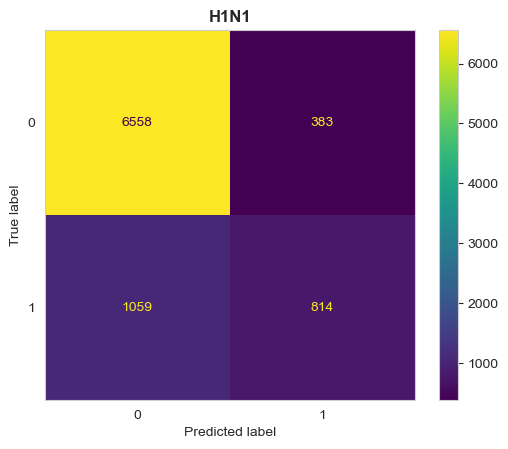

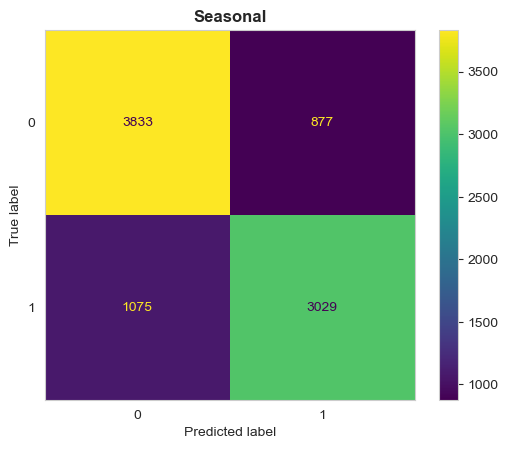

In [67]:
sns.set_style("whitegrid", {'axes.grid' : False})

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_seasonal)

disp.plot()
plt.title("H1N1", weight='bold')

disp_seasonal.plot()
plt.title("Seasonal", weight='bold')

plt.show();

In terms of the H1N1 model, the model was able to predict people who did not take the vaccine most of the time but did a poor job of predicting if the person did take the vaccine. Whereas the seasonal model did well in both predictions.

### Scores
The next metrics includes `precision`, `recall`, `accuracy`, and `f1` scores. `Precision()` tells us the ratio of true positives to the number of times the model predicted positive. `Recall()` tells us the ratio between the number of true positives to the number of actual total positives. `Accuracy()` is the number of true positives and true negatives divided by the total observations. It tells us how accurately the model made its predictions. And lastly, the `F1()` can be expressed as:$$ \text{F1 score} = 2\ \frac{Precision\ x\ Recall}{Precision + Recall} $$
A high F1 score means that the model is doing well all around. If the data has low drastically different precision and recall scores, it will be reflected in a poor F1 score.

In [68]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(X_test, y_test, full_pipeline):
    preds = full_pipeline.predict(X_test)
    print("Precision Score: {}".format(precision_score(y_test, preds)))
    print("Recall Score: {}".format(recall_score(y_test, preds)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, preds)))
    print("F1 Score: {}".format(f1_score(y_test, preds)))

In [69]:
print_metrics(X_test_h1n1, y_test_h1n1, pipelines(X_train_h1n1,
                                                  y_train_h1n1,
                                                  num_col_h1n1,
                                                  cat_col_h1n1)
             )

Precision Score: 0.6800334168755221
Recall Score: 0.4345969033635878
Accuracy Score: 0.8363966417063762
F1 Score: 0.5302931596091205


In [70]:
print_metrics(X_test_seasonal, y_test_seasonal, pipelines(X_train_seasonal,
                                                  y_train_seasonal,
                                                  num_col_seasonal,
                                                  cat_col_seasonal)
             )

Precision Score: 0.77547363031234
Recall Score: 0.7380604288499025
Accuracy Score: 0.7785341502155662
F1 Score: 0.7563046192259675


### Receiver operator characteristic curve
This curve plots the true positive rate (recall) against the false positive rate. If the area underneath the curve (AUC) equals 1, there is 100% chance that the model will distinguish between the positive and negative class. Of course, this is an ideal scenerio.

In [71]:
def ROC_curve(X, X_test, y, y_test, num_col, cat_col):
    full_pipeline = pipelines(X, y, num_col, cat_col)
    
    y_score = full_pipeline.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    return fpr, tpr, thresholds

This function will return the false positive rate (fpr) and true positive rate (tpr). These values will then be plotted to create the ROC curve.

In [72]:
def plot_ROC_curve(fpr, tpr, data_set='Training'):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for {} Set'.format(data_set))
    plt.legend(loc='lower right')
    plt.show()
    
    return  'AUC: {}'.format(auc(fpr, tpr))

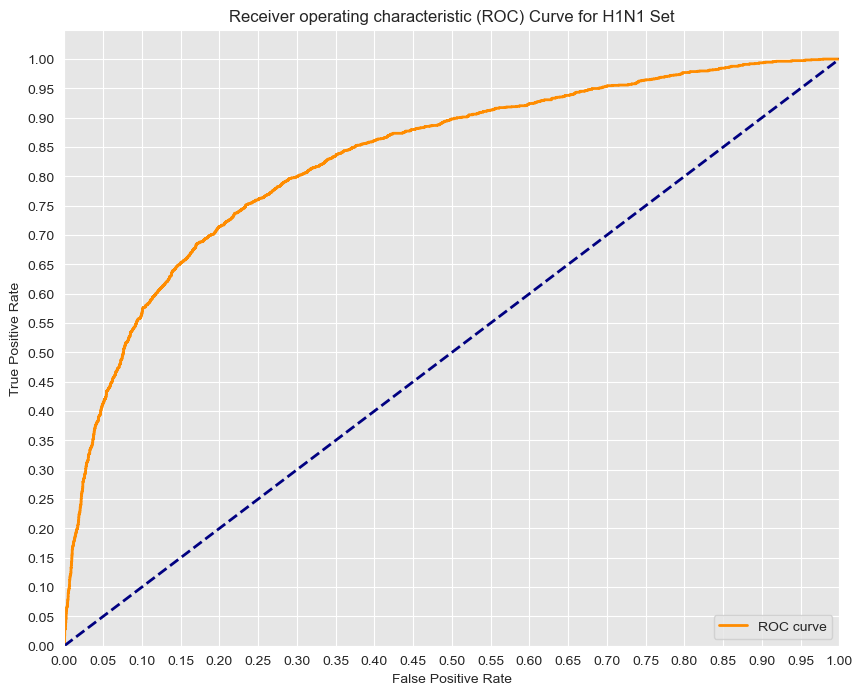

'AUC: 0.8292943967586459'

In [73]:
fpr, tpr, thresholds = ROC_curve(X_train_h1n1, X_test_h1n1, y_train_h1n1, y_test_h1n1, num_col_h1n1, cat_col_h1n1)

plot_ROC_curve(fpr, tpr, data_set='H1N1')

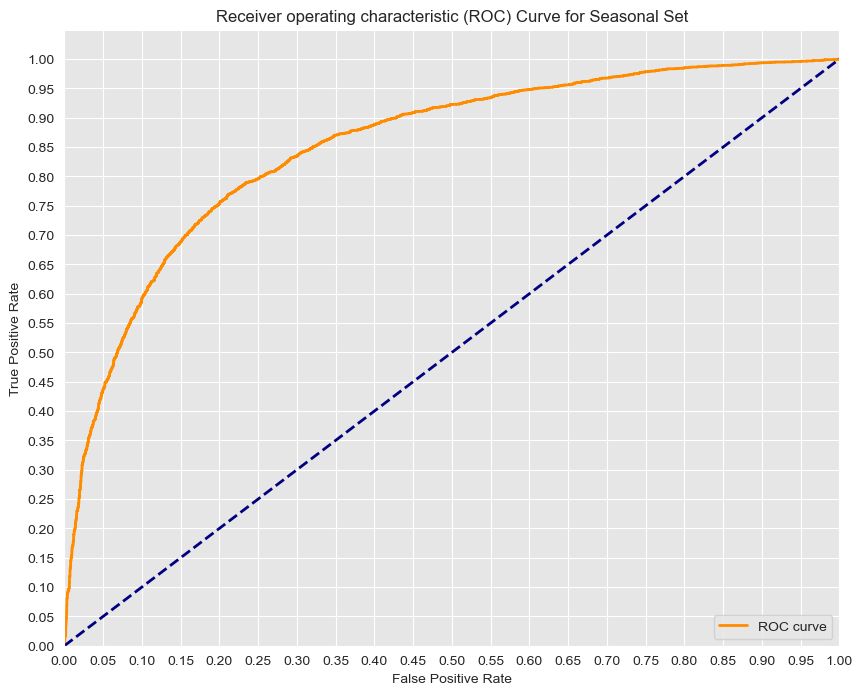

'AUC: 0.8507245791998279'

In [74]:
fpr, tpr, thresholds = ROC_curve(X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal, num_col_seasonal, cat_col_seasonal)

plot_ROC_curve(fpr, tpr, data_set='Seasonal')

The AUC for H1N1 and seasonal is `0.8292943967586459` and `0.8507245791998279` respectively. In terms of the H1N1 dataset, this means that the model is able to discern around 83% of the false positives and true positives. 

## Prediction

After understanding the model's performance, we can finally predict the results from the given test set, `test_set_features`. The predictions will be the probability of the respondent receiving the vaccines.

In [75]:
def predictions(full_pipeline, test_features):
    # predict the probability of a given data set 'test_features'
    predictions = full_pipeline.predict_proba(test_features)
    return predictions

In [76]:
# Input the pipelines into the function and store the predictions
Pipelines_h1n1 = pipelines(X_train_h1n1,
                           y_train_h1n1,
                           num_col_h1n1,
                           cat_col_h1n1)
y_hat_h1n1 = predictions(Pipelines_h1n1, test_set_features_df)

Pipelines_seasonal = pipelines(X_train_seasonal,
                               y_train_seasonal,
                               num_col_seasonal,
                               cat_col_seasonal)
y_hat_seasonal = predictions(Pipelines_seasonal, test_set_features_df)

Create a dataframe that holds all the predicted probability according to the corresponding `respondent_id`.

In [77]:
prob_df = pd.read_csv('submission_format.csv', index_col='respondent_id')
prob_df['h1n1_vaccine'] = y_hat_h1n1[:, 1]
prob_df['seasonal_vaccine'] = y_hat_seasonal[:, 1]
prob_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.091963,0.277842
26708,0.036076,0.049654
26709,0.487698,0.582256
26710,0.479471,0.866802
26711,0.149953,0.504796


Take the averages of each of the values to determine which vaccine is most likely to be taken.

In [78]:
print('Average probabilities of taking the H1N1 vaccine: ', prob_df.h1n1_vaccine.mean(), 
      '\nAverage probabilities of taking the seasonal flu vaccine: ', prob_df.seasonal_vaccine.mean())

Average probabilities of taking the H1N1 vaccine:  0.21048313100536317 
Average probabilities of taking the seasonal flu vaccine:  0.4621903288101224


According to the predicted results, more people are likely to take the seasonal flu vaccine than the H1N1 vaccine.

## Conclusion
From the data provided, we have found that the logistic model is best in making predictions, followed by the `KNeighborClassifier()` model (although it can be time consuming given the amount of data). Perhaps changing more parameters would yield results better than our logistic model. Still, the methods of obtaining the metrics of the model remains the same. Our logistic model yielded this confusion matrix:

|       | H1N1 | Seasonal |
|-----------------|------|-----|
| True positives  | 814 | 3029 |
| True negatives  | 6558 | 3833 |
| False positives | 383  | 877 |
| False negatives | 1059 | 1075 |

From this table, we can see that the seasonal model had better precision in predicting who will be vaccinated (ratio of true positives to false positives). However, the accuracy of the H1N1 model is greater (sum of true positives and true negatives). The scores obtained from `sklearn.metrics` are consistent with the matrices plotted. Overall the H1N1 model leaves a lot to be desired as it returns an `F1 score = 53%`. This is most likely due to the low `recall score = 43%`! The low recall score means the model is unable to successfully predict if a person did receive the vaccine. The seasonal model, on the otherhand, performed consistantly with each metric scoring above 70%. Assuming the best model is correctly choosen and the appropriate features are considered, we can conclude that seasonal vaccination rate is more predictable than the H1N1 vaccination rate.

#### Recommendation
People are more likely to receive the vaccine for the seasonal flu than the H1N1 virus. Assuming the development costs for both seasonal and H1N1 vaccines are similar, Pfizer can manufacture vaccines for the seasonal flu and expect higher profits.